In [15]:
import subprocess
import sys
import re
import glob
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import asyncio
from pathlib import Path
import os
import multiprocessing


## Lambda models

In [ ]:
!./train_lm.py vocab-englishspanish.txt add_lambda --lambda 1.0 ../data/english_spanish/train/en.1K --output en1k.model
!./train_lm.py vocab-englishspanish.txt add_lambda --lambda 1.0 ../data/english_spanish/train/sp.1K --output sp1k.model
!./textcat.py en1k.model sp1k.model 0.7 ../data/english_spanish/test/*/*/*

In [44]:
!./train_lm.py vocab-englishspanish.txt add_lambda --lambda 0.005 ../data/english_spanish/train/en.1K --output en1k_0.005.model
!./train_lm.py vocab-englishspanish.txt add_lambda --lambda 0.005 ../data/english_spanish/train/sp.1K --output sp1k_0.005.model
!./textcat.py en1k_0.005.model sp1k_0.005.model 0.7 ../data/english_spanish/test/*/*/*

!./train_lm.py vocab-englishspanish.txt add_lambda --lambda 0.05 ../data/english_spanish/train/en.1K --output en1k_0.05.model
!./train_lm.py vocab-englishspanish.txt add_lambda --lambda 0.05 ../data/english_spanish/train/sp.1K --output sp1k_0.05.model
!./textcat.py en1k_0.05.model sp1k_0.05.model 0.7 ../data/english_spanish/test/*/*/*

!./train_lm.py vocab-englishspanish.txt add_lambda --lambda 0.0005 ../data/english_spanish/train/en.1K --output en1k_0.0005.model
!./train_lm.py vocab-englishspanish.txt add_lambda --lambda 0.0005 ../data/english_spanish/train/sp.1K --output sp1k_0.0005.model
!./textcat.py en1k_0.0005.model sp1k_0.0005.model 0.7 ../data/english_spanish/test/*/*/*

!./train_lm.py vocab-englishspanish.txt add_lambda --lambda 0.5 ../data/english_spanish/train/en.1K --output en1k_0.5.model
!./train_lm.py vocab-englishspanish.txt add_lambda --lambda 0.5 ../data/english_spanish/train/sp.1K --output sp1k_0.5.model
!./textcat.py en1k_0.5.model sp1k_0.5.model 0.7 ../data/english_spanish/test/*/*/*

INFO:probs:Read vocab of size 84 from vocab-englishspanish.txt
INFO:train_lm:Training...
INFO:probs:Training from corpus ../data/english_spanish/train/en.1K
.
INFO:probs:Finished counting 1027 tokens
INFO:probs:Saving model to en1k_0.005.model
INFO:probs:Saved model to en1k_0.005.model
INFO:probs:Read vocab of size 84 from vocab-englishspanish.txt
INFO:train_lm:Training...
INFO:probs:Training from corpus ../data/english_spanish/train/sp.1K
.
INFO:probs:Finished counting 997 tokens
INFO:probs:Saving model to sp1k_0.005.model
INFO:probs:Saved model to sp1k_0.005.model
en1k_0.005.model	en.10.30
en1k_0.005.model	en.10.31
en1k_0.005.model	en.10.32
en1k_0.005.model	en.10.33
sp1k_0.005.model	en.10.34
en1k_0.005.model	en.10.35
en1k_0.005.model	en.10.36
sp1k_0.005.model	en.10.37
sp1k_0.005.model	en.10.38
en1k_0.005.model	en.10.39
en1k_0.005.model	en.10.40
en1k_0.005.model	en.10.41
en1k_0.005.model	en.10.42
sp1k_0.005.model	en.10.43
sp1k_0.005.model	en.10.44
sp1k_0.005.model	en.10.45
en1k_0.005.

In [16]:
## English-Spanish Lambda Analysis

lambda_cross_entropy_en_sp = []

# for lamda in [5, 0.5, 0.05, 0.005, 0.0005]:
for lamda in [0.005]:
    en_train_cmd = [
        "./train_lm.py",
        "vocab-englishspanish.txt",
        "add_lambda",
        "--lambda", f"{lamda}", 
        "../data/english_spanish/train/en.1K", 
        "--output", f"en~lambda={lamda}.model"
    ]

    sp_train_cmd = [
        "./train_lm.py",
        "vocab-englishspanish.txt",
        "add_lambda",
        "--lambda", f"{lamda}", 
        "../data/english_spanish/train/sp.1K", 
        "--output", f"sp~lambda={lamda}.model"
    ]
    
    en_output_model = subprocess.run(en_train_cmd, capture_output=True, text=True)
    sp_output_model = subprocess.run(sp_train_cmd, capture_output=True, text=True)
    
    # Get all English dev files
    en_dev_files = []
    for length in ['10', '20', '50', '100', '200', '500']:
        en_dev_files.extend(glob.glob(f"../data/english_spanish/dev/english/length-{length}/*"))
    
    # Get all Spanish dev files  
    sp_dev_files = []
    for length in ['10', '20', '50', '100', '200', '500']:
        sp_dev_files.extend(glob.glob(f"../data/english_spanish/dev/spanish/length-{length}/*"))
    
    en_fileprob_cmd = ["./fileprob.py", f"en~lambda={lamda}.model"] + en_dev_files
    sp_fileprob_cmd = ["./fileprob.py", f"sp~lambda={lamda}.model"] + sp_dev_files
    
    en_output = subprocess.run(en_fileprob_cmd, capture_output=True, text=True).stdout
    sp_output = subprocess.run(sp_fileprob_cmd, capture_output=True, text=True).stdout

    en_vocab_counts = int(en_output.strip().split("\n")[-2].strip().split(":")[-1].strip())
    sp_vocab_counts = int(sp_output.strip().split("\n")[-2].strip().split(":")[-1].strip())
    
    en_overall_cross_entropy_str = en_output.strip().split("\n")[-1]
    sp_overall_cross_entropy_str = sp_output.strip().split("\n")[-1]
    
    en_cross_entropy_str = en_output.strip().split("\n")[-3]
    sp_cross_entropy_str = sp_output.strip().split("\n")[-3]
    
    en_cross_entropy = float(re.search(r"(\d+\.\d+)", en_cross_entropy_str.split(":")[-1].strip()).group(1))
    sp_cross_entropy = float(re.search(r"(\d+\.\d+)", sp_cross_entropy_str.split(":")[-1].strip()).group(1))
        
    en_overall_cross_entropy = float(re.search(r"(\d+\.\d+)", en_overall_cross_entropy_str.split(":")[-1].strip()).group(1))
    sp_overall_cross_entropy = float(re.search(r"(\d+\.\d+)", sp_overall_cross_entropy_str.split(":")[-1].strip()).group(1))
    
    overall_cross_entropy = (en_cross_entropy + sp_cross_entropy) / (en_vocab_counts + sp_vocab_counts)
    
    print(lamda, en_cross_entropy, sp_cross_entropy, overall_cross_entropy)

    lambda_cross_entropy_en_sp.append({
        "lambda": lamda,
        "en_cross_entropy": en_cross_entropy,
        "sp_cross_entropy": sp_cross_entropy,
        "en_overall_cross_entropy": en_overall_cross_entropy,
        "sp_overall_cross_entropy": sp_overall_cross_entropy,
        "en_vocab_counts": en_vocab_counts,
        "sp_vocab_counts": sp_vocab_counts,
        "overall_cross_entropy": overall_cross_entropy
        
    })


0.005 98611.12910266926 94431.17357951366 5.4857147678938025


In [17]:
## English-Spanish Multiple Lambda Analysis

lambda_cross_entropy_en_sp_multiple = []

for lamda in [5, 0.5, 0.05, 0.005, 0.0005]:
    print(f"Processing lambda = {lamda}")
    
    en_train_cmd = [
        "./train_lm.py",
        "vocab-englishspanish.txt",
        "add_lambda",
        "--lambda", f"{lamda}", 
        "../data/english_spanish/train/en.1K", 
        "--output", f"en~lambda={lamda}.model"
    ]

    sp_train_cmd = [
        "./train_lm.py",
        "vocab-englishspanish.txt",
        "add_lambda",
        "--lambda", f"{lamda}", 
        "../data/english_spanish/train/sp.1K", 
        "--output", f"sp~lambda={lamda}.model"
    ]
    
    en_output_model = subprocess.run(en_train_cmd, capture_output=True, text=True)
    sp_output_model = subprocess.run(sp_train_cmd, capture_output=True, text=True)
    
    # Get all English dev files
    en_dev_files = []
    for length in ['10', '20', '50', '100', '200', '500']:
        en_dev_files.extend(glob.glob(f"../data/english_spanish/dev/english/length-{length}/*"))
    
    # Get all Spanish dev files  
    sp_dev_files = []
    for length in ['10', '20', '50', '100', '200', '500']:
        sp_dev_files.extend(glob.glob(f"../data/english_spanish/dev/spanish/length-{length}/*"))
    
    en_fileprob_cmd = ["./fileprob.py", f"en~lambda={lamda}.model"] + en_dev_files
    sp_fileprob_cmd = ["./fileprob.py", f"sp~lambda={lamda}.model"] + sp_dev_files
    
    en_output = subprocess.run(en_fileprob_cmd, capture_output=True, text=True).stdout
    sp_output = subprocess.run(sp_fileprob_cmd, capture_output=True, text=True).stdout

    en_vocab_counts = int(en_output.strip().split("\n")[-2].strip().split(":")[-1].strip())
    sp_vocab_counts = int(sp_output.strip().split("\n")[-2].strip().split(":")[-1].strip())
    
    en_overall_cross_entropy_str = en_output.strip().split("\n")[-1]
    sp_overall_cross_entropy_str = sp_output.strip().split("\n")[-1]
    
    en_cross_entropy_str = en_output.strip().split("\n")[-3]
    sp_cross_entropy_str = sp_output.strip().split("\n")[-3]
    
    en_cross_entropy = float(re.search(r"(\d+\.\d+)", en_cross_entropy_str.split(":")[-1].strip()).group(1))
    sp_cross_entropy = float(re.search(r"(\d+\.\d+)", sp_cross_entropy_str.split(":")[-1].strip()).group(1))
        
    en_overall_cross_entropy = float(re.search(r"(\d+\.\d+)", en_overall_cross_entropy_str.split(":")[-1].strip()).group(1))
    sp_overall_cross_entropy = float(re.search(r"(\d+\.\d+)", sp_overall_cross_entropy_str.split(":")[-1].strip()).group(1))
    
    overall_cross_entropy = (en_cross_entropy + sp_cross_entropy) / (en_vocab_counts + sp_vocab_counts)
    
    print(f"Lambda: {lamda}, EN Cross-entropy: {en_cross_entropy:.4f}, SP Cross-entropy: {sp_cross_entropy:.4f}, Overall: {overall_cross_entropy:.4f}")

    lambda_cross_entropy_en_sp_multiple.append({
        "lambda": lamda,
        "en_cross_entropy": en_cross_entropy,
        "sp_cross_entropy": sp_cross_entropy,
        "en_overall_cross_entropy": en_overall_cross_entropy,
        "sp_overall_cross_entropy": sp_overall_cross_entropy,
        "en_vocab_counts": en_vocab_counts,
        "sp_vocab_counts": sp_vocab_counts,
        "overall_cross_entropy": overall_cross_entropy
        
    })


Processing lambda = 5
Lambda: 5, EN Cross-entropy: 107977.4716, SP Cross-entropy: 105645.1953, Overall: 6.0706
Processing lambda = 0.5
Lambda: 0.5, EN Cross-entropy: 95449.8170, SP Cross-entropy: 91989.6920, Overall: 5.3265
Processing lambda = 0.05
Lambda: 0.05, EN Cross-entropy: 87910.3691, SP Cross-entropy: 84347.2356, Overall: 4.8951
Processing lambda = 0.005
Lambda: 0.005, EN Cross-entropy: 98611.1291, SP Cross-entropy: 94431.1736, Overall: 5.4857
Processing lambda = 0.0005
Lambda: 0.0005, EN Cross-entropy: 118345.3438, SP Cross-entropy: 112211.2849, Overall: 6.5518


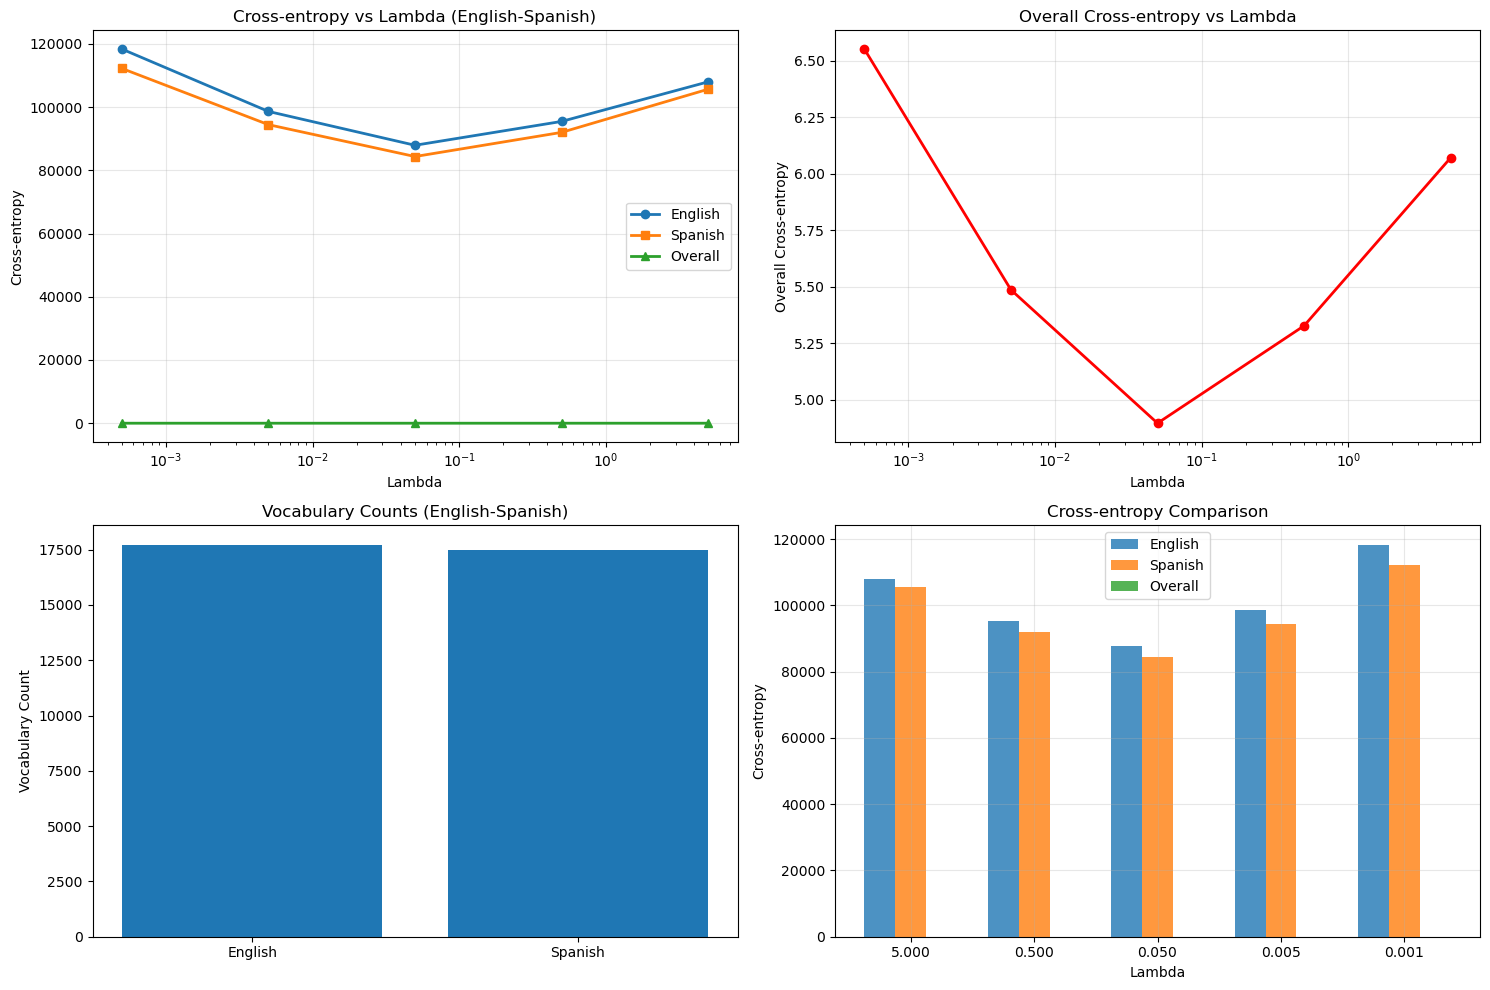


English-Spanish Lambda Analysis Summary:
Lambda:    5.000 | EN: 107977.4716 | SP: 105645.1953 | Overall:   6.0706
Lambda:    0.500 | EN: 95449.8170 | SP: 91989.6920 | Overall:   5.3265
Lambda:    0.050 | EN: 87910.3691 | SP: 84347.2356 | Overall:   4.8951
Lambda:    0.005 | EN: 98611.1291 | SP: 94431.1736 | Overall:   5.4857
Lambda:    0.001 | EN: 118345.3438 | SP: 112211.2849 | Overall:   6.5518


In [18]:
## Visualization of English-Spanish Lambda Results

# Convert to DataFrame for easier plotting
df_en_sp = pd.DataFrame(lambda_cross_entropy_en_sp_multiple)

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Cross-entropy vs Lambda
axes[0, 0].semilogx(df_en_sp['lambda'], df_en_sp['en_cross_entropy'], 'o-', label='English', linewidth=2)
axes[0, 0].semilogx(df_en_sp['lambda'], df_en_sp['sp_cross_entropy'], 's-', label='Spanish', linewidth=2)
axes[0, 0].semilogx(df_en_sp['lambda'], df_en_sp['overall_cross_entropy'], '^-', label='Overall', linewidth=2)
axes[0, 0].set_xlabel('Lambda')
axes[0, 0].set_ylabel('Cross-entropy')
axes[0, 0].set_title('Cross-entropy vs Lambda (English-Spanish)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Overall cross-entropy vs Lambda
axes[0, 1].semilogx(df_en_sp['lambda'], df_en_sp['overall_cross_entropy'], 'o-', color='red', linewidth=2)
axes[0, 1].set_xlabel('Lambda')
axes[0, 1].set_ylabel('Overall Cross-entropy')
axes[0, 1].set_title('Overall Cross-entropy vs Lambda')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Vocabulary counts
axes[1, 0].bar(['English', 'Spanish'], [df_en_sp['en_vocab_counts'].iloc[0], df_en_sp['sp_vocab_counts'].iloc[0]])
axes[1, 0].set_ylabel('Vocabulary Count')
axes[1, 0].set_title('Vocabulary Counts (English-Spanish)')

# Plot 4: Cross-entropy comparison
x_pos = range(len(df_en_sp))
width = 0.25
axes[1, 1].bar([x - width for x in x_pos], df_en_sp['en_cross_entropy'], width, label='English', alpha=0.8)
axes[1, 1].bar(x_pos, df_en_sp['sp_cross_entropy'], width, label='Spanish', alpha=0.8)
axes[1, 1].bar([x + width for x in x_pos], df_en_sp['overall_cross_entropy'], width, label='Overall', alpha=0.8)
axes[1, 1].set_xlabel('Lambda')
axes[1, 1].set_ylabel('Cross-entropy')
axes[1, 1].set_title('Cross-entropy Comparison')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([f'{lam:.3f}' for lam in df_en_sp['lambda']])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary table
print("\nEnglish-Spanish Lambda Analysis Summary:")
print("=" * 50)
for _, row in df_en_sp.iterrows():
    print(f"Lambda: {row['lambda']:>8.3f} | EN: {row['en_cross_entropy']:>8.4f} | SP: {row['sp_cross_entropy']:>8.4f} | Overall: {row['overall_cross_entropy']:>8.4f}")


In [21]:
## English-Spanish File-level Analysis (Similar to Gen-Spam)

# Get individual file cross-entropy for English-Spanish
en_file_cross_entropy = []
sp_file_cross_entropy = []

# Use lambda=0.005 (from previous analysis)
lambda_val = 0.005

print("Analyzing individual files for English-Spanish...")

# Get all English dev files
en_dev_files = []
for length in ['10', '20', '50', '100', '200', '500']:
    en_dev_files.extend(glob.glob(f"../data/english_spanish/dev/english/length-{length}/*"))

# Get all Spanish dev files  
sp_dev_files = []
for length in ['10', '20', '50', '100', '200', '500']:
    sp_dev_files.extend(glob.glob(f"../data/english_spanish/dev/spanish/length-{length}/*"))

print(f"Found {len(en_dev_files)} English files and {len(sp_dev_files)} Spanish files")

# Analyze English files
for i, file_path in enumerate(en_dev_files):
    # Get cross-entropy from English model
    en_cmd = ["./fileprob.py", f"en~lambda={lambda_val}.model", file_path]
    en_output = subprocess.run(en_cmd, capture_output=True, text=True).stdout
    
    # Get cross-entropy from Spanish model
    sp_cmd = ["./fileprob.py", f"sp~lambda={lambda_val}.model", file_path]
    sp_output = subprocess.run(sp_cmd, capture_output=True, text=True).stdout
    
    # Parse cross-entropy and vocab count
    # The output format is: "Overall cross-entropy:\t{value} bits per token"
    en_cross_entropy = float(en_output.strip().split('\n')[-1].split('\t')[-1].split()[0])
    sp_cross_entropy = float(sp_output.strip().split('\n')[-1].split('\t')[-1].split()[0])
    vocab_count = int(en_output.strip().split('\n')[-2].split('\t')[-1])
    
    en_file_cross_entropy.append({
        'file': file_path,
        'vocab_counts': vocab_count,
        'cross_entropy': en_cross_entropy,
        'sp_cross_entropy': sp_cross_entropy
    })

# Analyze Spanish files
for i, file_path in enumerate(sp_dev_files):
    # Get cross-entropy from English model
    en_cmd = ["./fileprob.py", f"en~lambda={lambda_val}.model", file_path]
    en_output = subprocess.run(en_cmd, capture_output=True, text=True).stdout
    
    # Get cross-entropy from Spanish model
    sp_cmd = ["./fileprob.py", f"sp~lambda={lambda_val}.model", file_path]
    sp_output = subprocess.run(sp_cmd, capture_output=True, text=True).stdout
    
    # Parse cross-entropy and vocab count
    # The output format is: "Overall cross-entropy:\t{value} bits per token"
    en_cross_entropy = float(en_output.strip().split('\n')[-1].split('\t')[-1].split()[0])
    sp_cross_entropy = float(sp_output.strip().split('\n')[-1].split('\t')[-1].split()[0])
    vocab_count = int(sp_output.strip().split('\n')[-2].split('\t')[-1])
    
    sp_file_cross_entropy.append({
        'file': file_path,
        'vocab_counts': vocab_count,
        'cross_entropy': sp_cross_entropy,
        'en_cross_entropy': en_cross_entropy
    })

print(f"Analyzed {len(en_file_cross_entropy)} English files and {len(sp_file_cross_entropy)} Spanish files")


Analyzing individual files for English-Spanish...
Found 120 English files and 119 Spanish files
Analyzed 120 English files and 119 Spanish files


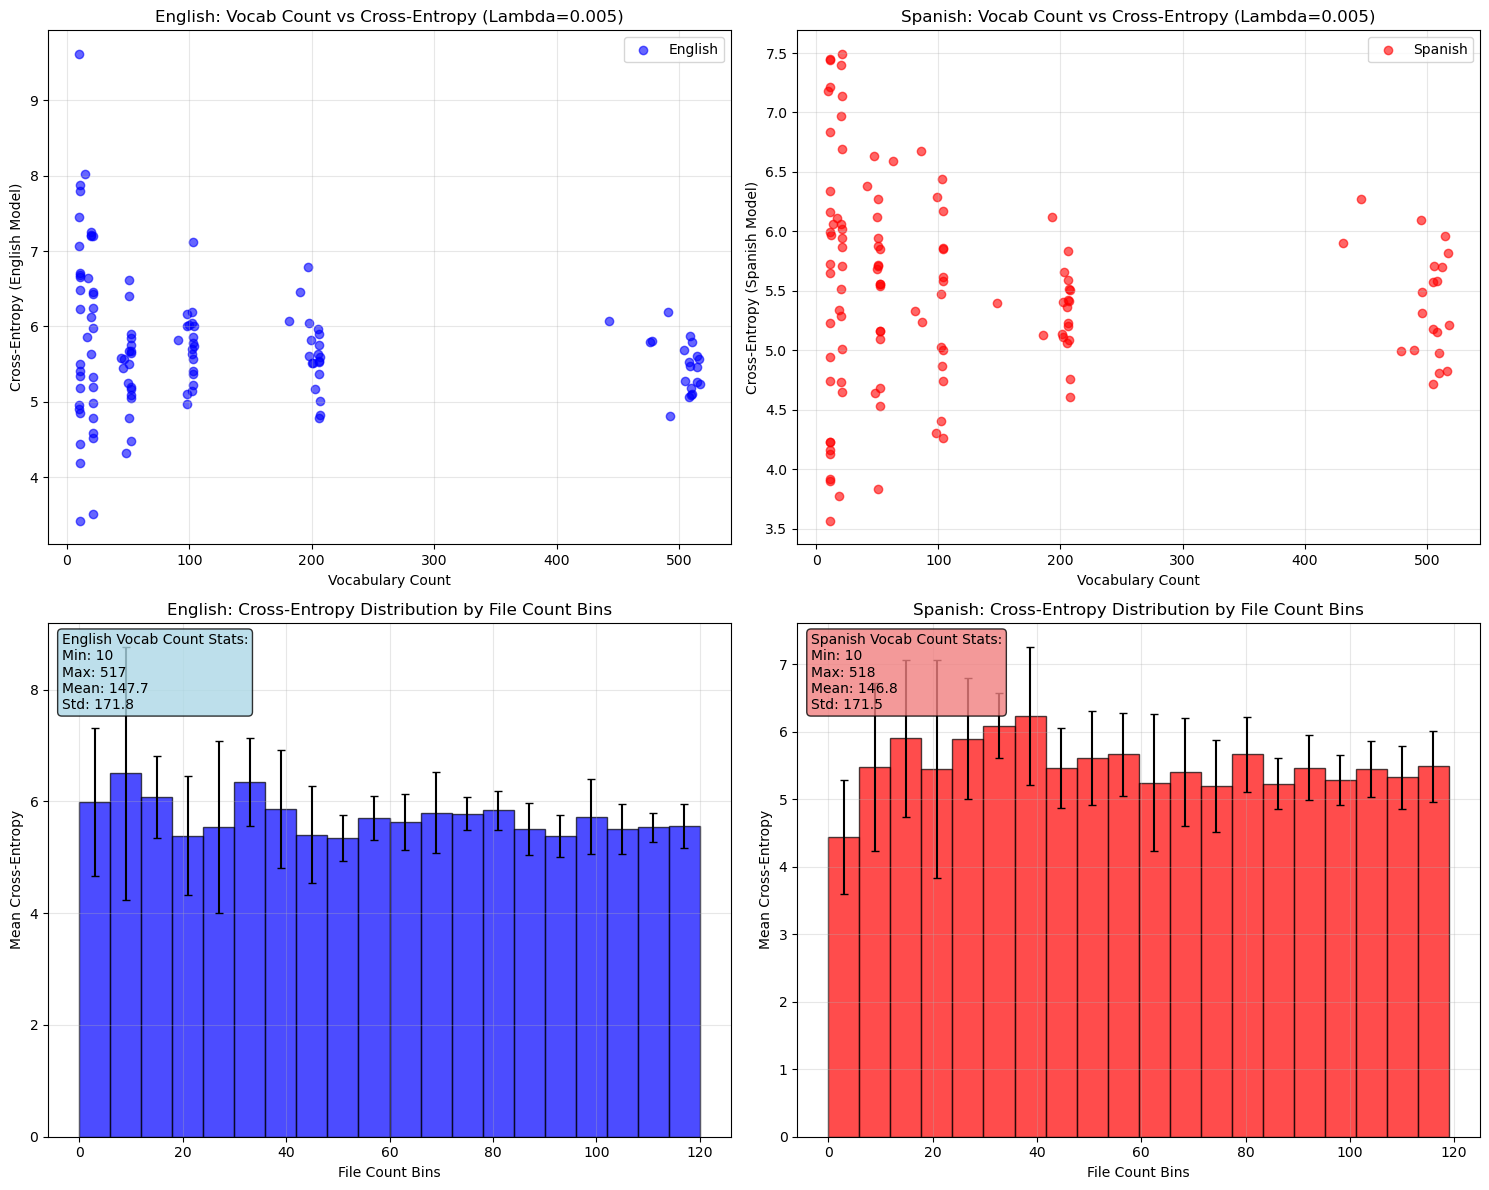

In [22]:
# Create side-by-side plots for English-Spanish data (lambda=0.005)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Convert to DataFrames
en_df = pd.DataFrame(en_file_cross_entropy)
sp_df = pd.DataFrame(sp_file_cross_entropy)

# Plot 1: Scatter plot of vocab count against cross-entropy for English
ax1.scatter(en_df['vocab_counts'], en_df['cross_entropy'], alpha=0.6, color='blue', label='English')
ax1.set_xlabel('Vocabulary Count')
ax1.set_ylabel('Cross-Entropy (English Model)')
ax1.set_title('English: Vocab Count vs Cross-Entropy (Lambda=0.005)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Scatter plot of vocab count against cross-entropy for Spanish
ax2.scatter(sp_df['vocab_counts'], sp_df['cross_entropy'], alpha=0.6, color='red', label='Spanish')
ax2.set_xlabel('Vocabulary Count')
ax2.set_ylabel('Cross-Entropy (Spanish Model)')
ax2.set_title('Spanish: Vocab Count vs Cross-Entropy (Lambda=0.005)')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Histogram with bins for English
num_bins = 20
file_indices = range(len(en_df))
bin_edges = np.linspace(0, len(en_df), num_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate mean cross-entropy for each bin (English)
bin_means_en = []
bin_stds_en = []
for i in range(num_bins):
    start_idx = int(bin_edges[i])
    end_idx = int(bin_edges[i + 1])
    if start_idx < len(en_df):
        bin_data = en_df.iloc[start_idx:end_idx]['cross_entropy']
        bin_means_en.append(bin_data.mean())
        bin_stds_en.append(bin_data.std())

# Create histogram with error bars for English
ax3.bar(bin_centers, bin_means_en, width=bin_edges[1] - bin_edges[0], 
        alpha=0.7, color='blue', edgecolor='black', yerr=bin_stds_en, capsize=3)
ax3.set_xlabel('File Count Bins')
ax3.set_ylabel('Mean Cross-Entropy')
ax3.set_title('English: Cross-Entropy Distribution by File Count Bins')
ax3.grid(True, alpha=0.3)

# Add text annotation showing vocab count statistics for English
en_vocab_stats = f"English Vocab Count Stats:\nMin: {en_df['vocab_counts'].min()}\nMax: {en_df['vocab_counts'].max()}\nMean: {en_df['vocab_counts'].mean():.1f}\nStd: {en_df['vocab_counts'].std():.1f}"
ax3.text(0.02, 0.98, en_vocab_stats, transform=ax3.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Plot 4: Histogram with bins for Spanish
file_indices_sp = range(len(sp_df))
bin_edges_sp = np.linspace(0, len(sp_df), num_bins + 1)
bin_centers_sp = (bin_edges_sp[:-1] + bin_edges_sp[1:]) / 2

# Calculate mean cross-entropy for each bin (Spanish)
bin_means_sp = []
bin_stds_sp = []
for i in range(num_bins):
    start_idx = int(bin_edges_sp[i])
    end_idx = int(bin_edges_sp[i + 1])
    if start_idx < len(sp_df):
        bin_data = sp_df.iloc[start_idx:end_idx]['cross_entropy']
        bin_means_sp.append(bin_data.mean())
        bin_stds_sp.append(bin_data.std())

# Create histogram with error bars for Spanish
ax4.bar(bin_centers_sp, bin_means_sp, width=bin_edges_sp[1] - bin_edges_sp[0], 
        alpha=0.7, color='red', edgecolor='black', yerr=bin_stds_sp, capsize=3)
ax4.set_xlabel('File Count Bins')
ax4.set_ylabel('Mean Cross-Entropy')
ax4.set_title('Spanish: Cross-Entropy Distribution by File Count Bins')
ax4.grid(True, alpha=0.3)

# Add text annotation showing vocab count statistics for Spanish
sp_vocab_stats = f"Spanish Vocab Count Stats:\nMin: {sp_df['vocab_counts'].min()}\nMax: {sp_df['vocab_counts'].max()}\nMean: {sp_df['vocab_counts'].mean():.1f}\nStd: {sp_df['vocab_counts'].std():.1f}"
ax4.text(0.02, 0.98, sp_vocab_stats, transform=ax4.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

plt.tight_layout()
plt.show()


In [23]:
# Additional analysis for English-Spanish: Cross-entropy vs vocab count correlation
print("ENGLISH-SPANISH DATA ANALYSIS:")
print("="*60)

print("\nEnglish data correlation between vocab count and cross-entropy:")
en_correlation = en_df['vocab_counts'].corr(en_df['cross_entropy'])
print(f"Correlation coefficient: {en_correlation:.4f}")

print("\nEnglish vocab count statistics:")
print(en_df['vocab_counts'].describe())

print("\nEnglish cross-entropy statistics:")
print(en_df['cross_entropy'].describe())

print("\n" + "-"*40)

print("\nSpanish data correlation between vocab count and cross-entropy:")
sp_correlation = sp_df['vocab_counts'].corr(sp_df['cross_entropy'])
print(f"Correlation coefficient: {sp_correlation:.4f}")

print("\nSpanish vocab count statistics:")
print(sp_df['vocab_counts'].describe())

print("\nSpanish cross-entropy statistics:")
print(sp_df['cross_entropy'].describe())

print("\n" + "="*60)
print("COMPARISON: English vs Spanish")
print("="*60)
print(f"English correlation: {en_correlation:.4f}")
print(f"Spanish correlation: {sp_correlation:.4f}")
print(f"English mean vocab count: {en_df['vocab_counts'].mean():.1f}")
print(f"Spanish mean vocab count: {sp_df['vocab_counts'].mean():.1f}")
print(f"English mean cross-entropy: {en_df['cross_entropy'].mean():.4f}")
print(f"Spanish mean cross-entropy: {sp_df['cross_entropy'].mean():.4f}")

# Language identification accuracy analysis
print("\n" + "="*60)
print("LANGUAGE IDENTIFICATION ANALYSIS")
print("="*60)

# For English files: English model should have lower cross-entropy
en_correct = sum(1 for i in range(len(en_df)) if en_df.iloc[i]['cross_entropy'] < en_df.iloc[i]['sp_cross_entropy'])
en_total = len(en_df)
en_accuracy = en_correct / en_total

# For Spanish files: Spanish model should have lower cross-entropy  
sp_correct = sum(1 for i in range(len(sp_df)) if sp_df.iloc[i]['cross_entropy'] < sp_df.iloc[i]['en_cross_entropy'])
sp_total = len(sp_df)
sp_accuracy = sp_correct / sp_total

overall_correct = en_correct + sp_correct
overall_total = en_total + sp_total
overall_accuracy = overall_correct / overall_total

print(f"English files correctly identified: {en_correct}/{en_total} ({en_accuracy:.4f})")
print(f"Spanish files correctly identified: {sp_correct}/{sp_total} ({sp_accuracy:.4f})")
print(f"Overall accuracy: {overall_correct}/{overall_total} ({overall_accuracy:.4f})")


ENGLISH-SPANISH DATA ANALYSIS:

English data correlation between vocab count and cross-entropy:
Correlation coefficient: -0.1560

English vocab count statistics:
count    120.000000
mean     147.708333
std      171.814410
min       10.000000
25%       21.000000
50%       71.500000
75%      205.000000
max      517.000000
Name: vocab_counts, dtype: float64

English cross-entropy statistics:
count    120.000000
mean       5.720690
std        0.874345
min        3.418150
25%        5.192902
50%        5.622090
75%        6.047398
max        9.619870
Name: cross_entropy, dtype: float64

----------------------------------------

Spanish data correlation between vocab count and cross-entropy:
Correlation coefficient: -0.1054

Spanish vocab count statistics:
count    119.000000
mean     146.764706
std      171.495402
min       10.000000
25%       20.000000
50%       52.000000
75%      206.000000
max      518.000000
Name: vocab_counts, dtype: float64

Spanish cross-entropy statistics:
count    

In [24]:
## English-Spanish Learning Curve Analysis

# Define training data sizes for English-Spanish
en_sp_training_sizes = {
    '1K': {'en': 'en.1K', 'sp': 'sp.1K'},
    '2K': {'en': 'en.2K', 'sp': 'sp.2K'},
    '5K': {'en': 'en.5K', 'sp': 'sp.5K'},
    '10K': {'en': 'en.10K', 'sp': 'sp.10K'},
    '20K': {'en': 'en.20K', 'sp': 'sp.20K'},
    '50K': {'en': 'en.50K', 'sp': 'sp.50K'}
}

# Use lambda=0.005 (from previous analysis)
lambda_val = 0.005
en_sp_learning_curve_data = []

print("Training English-Spanish models with different data sizes...")
print("="*70)

for size_name, files in en_sp_training_sizes.items():
    print(f"\nTraining with {size_name} data...")
    
    # Train English model
    en_train_cmd = [
        "./train_lm.py",
        "vocab-englishspanish.txt",
        "add_lambda",
        "--lambda", f"{lambda_val}", 
        f"../data/english_spanish/train/{files['en']}", 
        "--output", f"en_{size_name}_lambda_{lambda_val}.model"
    ]
    
    # Train Spanish model
    sp_train_cmd = [
        "./train_lm.py",
        "vocab-englishspanish.txt",
        "add_lambda",
        "--lambda", f"{lambda_val}", 
        f"../data/english_spanish/train/{files['sp']}", 
        "--output", f"sp_{size_name}_lambda_{lambda_val}.model"
    ]
    
    # Train models
    en_output = subprocess.run(en_train_cmd, capture_output=True, text=True)
    sp_output = subprocess.run(sp_train_cmd, capture_output=True, text=True)
    
    print(f"English model trained: {en_output.returncode == 0}")
    print(f"Spanish model trained: {sp_output.returncode == 0}")
    
    # Test on dev data
    en_dev_files = []
    for length in ['10', '20', '50', '100', '200', '500']:
        en_dev_files.extend(glob.glob(f"../data/english_spanish/dev/english/length-{length}/*"))
    
    sp_dev_files = []
    for length in ['10', '20', '50', '100', '200', '500']:
        sp_dev_files.extend(glob.glob(f"../data/english_spanish/dev/spanish/length-{length}/*"))
    
    # Get predictions for English dev files
    en_en_cmd = ["./fileprob.py", f"en_{size_name}_lambda_{lambda_val}.model"] + en_dev_files
    en_sp_cmd = ["./fileprob.py", f"sp_{size_name}_lambda_{lambda_val}.model"] + en_dev_files
    
    en_en_output = subprocess.run(en_en_cmd, capture_output=True, text=True).stdout
    en_sp_output = subprocess.run(en_sp_cmd, capture_output=True, text=True).stdout
    
    # Get predictions for Spanish dev files
    sp_en_cmd = ["./fileprob.py", f"en_{size_name}_lambda_{lambda_val}.model"] + sp_dev_files
    sp_sp_cmd = ["./fileprob.py", f"sp_{size_name}_lambda_{lambda_val}.model"] + sp_dev_files
    
    sp_en_output = subprocess.run(sp_en_cmd, capture_output=True, text=True).stdout
    sp_sp_output = subprocess.run(sp_sp_cmd, capture_output=True, text=True).stdout
    
    # Parse cross-entropy values
    en_en_scores = []
    en_sp_scores = []
    sp_en_scores = []
    sp_sp_scores = []
    
    for line in en_en_output.strip().split('\n')[:-3]:
        if line.strip():
            score = float(line.split('\t')[0])
            en_en_scores.append(score)
    
    for line in en_sp_output.strip().split('\n')[:-3]:
        if line.strip():
            score = float(line.split('\t')[0])
            en_sp_scores.append(score)
    
    for line in sp_en_output.strip().split('\n')[:-3]:
        if line.strip():
            score = float(line.split('\t')[0])
            sp_en_scores.append(score)
    
    for line in sp_sp_output.strip().split('\n')[:-3]:
        if line.strip():
            score = float(line.split('\t')[0])
            sp_sp_scores.append(score)
    
    # Calculate error rate (lower cross-entropy = better model for that class)
    en_correct = sum(1 for i in range(len(en_en_scores)) if en_en_scores[i] < en_sp_scores[i])
    sp_correct = sum(1 for i in range(len(sp_sp_scores)) if sp_sp_scores[i] < sp_en_scores[i])
    
    total_files = len(en_en_scores) + len(sp_sp_scores)
    total_correct = en_correct + sp_correct
    error_rate = 1 - (total_correct / total_files)
    
    print(f"English files: {en_correct}/{len(en_en_scores)} correct")
    print(f"Spanish files: {sp_correct}/{len(sp_sp_scores)} correct")
    print(f"Overall error rate: {error_rate:.4f}")
    
    # Convert size to numeric for plotting
    size_numeric = int(size_name.replace('K', ''))
    
    en_sp_learning_curve_data.append({
        'size': size_name,
        'size_numeric': size_numeric,
        'error_rate': error_rate,
        'en_correct': en_correct,
        'sp_correct': sp_correct,
        'total_files': total_files
    })

print("\n" + "="*70)
print("ENGLISH-SPANISH LEARNING CURVE RESULTS:")
print("="*70)
for data in en_sp_learning_curve_data:
    print(f"{data['size']}: Error rate = {data['error_rate']:.4f}")


Training English-Spanish models with different data sizes...

Training with 1K data...
English model trained: True
Spanish model trained: True
English files: 104/120 correct
Spanish files: 111/119 correct
Overall error rate: 0.1004

Training with 2K data...
English model trained: True
Spanish model trained: True
English files: 108/120 correct
Spanish files: 101/119 correct
Overall error rate: 0.1255

Training with 5K data...
English model trained: True
Spanish model trained: True
English files: 112/120 correct
Spanish files: 105/119 correct
Overall error rate: 0.0921

Training with 10K data...
English model trained: True
Spanish model trained: True
English files: 117/120 correct
Spanish files: 114/119 correct
Overall error rate: 0.0335

Training with 20K data...
English model trained: True
Spanish model trained: True
English files: 116/120 correct
Spanish files: 116/119 correct
Overall error rate: 0.0293

Training with 50K data...
English model trained: True
Spanish model trained: True

/var/folders/5p/4fxsw8m57ngf99_vmdxcpjwc0000gn/T/ipykernel_44147/2829539522.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(en_sp_lc_df['size_numeric'], en_sp_lc_df['error_rate'], 'bo-', linewidth=3, markersize=10, label='English-Spanish Error Rate', color='green')


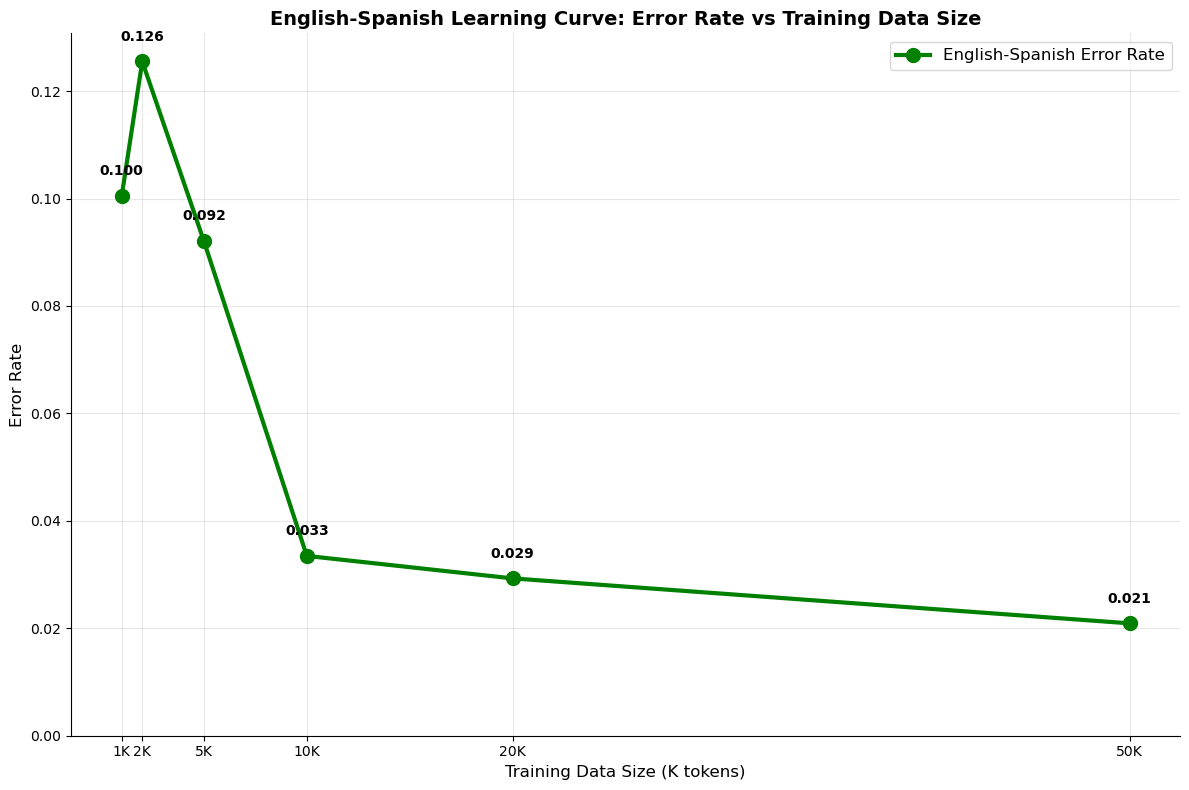


DETAILED ENGLISH-SPANISH LEARNING CURVE ANALYSIS:
Training Size: 1K
  Error Rate: 0.1004
  English Correct: 104
  Spanish Correct: 111
  Total Files: 239

Training Size: 2K
  Error Rate: 0.1255
  English Correct: 108
  Spanish Correct: 101
  Total Files: 239

Training Size: 5K
  Error Rate: 0.0921
  English Correct: 112
  Spanish Correct: 105
  Total Files: 239

Training Size: 10K
  Error Rate: 0.0335
  English Correct: 117
  Spanish Correct: 114
  Total Files: 239

Training Size: 20K
  Error Rate: 0.0293
  English Correct: 116
  Spanish Correct: 116
  Total Files: 239

Training Size: 50K
  Error Rate: 0.0209
  English Correct: 116
  Spanish Correct: 118
  Total Files: 239

ENGLISH-SPANISH LEARNING CURVE ANALYSIS:
Initial error rate (1K): 0.1004
Final error rate (50K): 0.0209
Improvement: 0.0795
Relative improvement: 79.2%
Error rate is decreasing: False

Expected behavior: Error rate should generally decrease as training data increases.
However, error rate may not approach 0 due to:


In [26]:
# Create learning curve plot for English-Spanish
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Convert data to DataFrame for easier plotting
en_sp_lc_df = pd.DataFrame(en_sp_learning_curve_data)

# Plot learning curve
ax.plot(en_sp_lc_df['size_numeric'], en_sp_lc_df['error_rate'], 'bo-', linewidth=3, markersize=10, label='English-Spanish Error Rate', color='green')
ax.set_xlabel('Training Data Size (K tokens)', fontsize=12)
ax.set_ylabel('Error Rate', fontsize=12)
ax.set_title('English-Spanish Learning Curve: Error Rate vs Training Data Size', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)

# Add data point labels
for i, row in en_sp_lc_df.iterrows():
    ax.annotate(f'{row["error_rate"]:.3f}', 
                (row['size_numeric'], row['error_rate']), 
                textcoords="offset points", 
                xytext=(0,15), 
                ha='center',
                fontsize=10,
                fontweight='bold')

# Set x-axis to show training data sizes
ax.set_xticks(en_sp_lc_df['size_numeric'])
ax.set_xticklabels([f'{size}K' for size in en_sp_lc_df['size_numeric']])

# Add some styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(bottom=0)  # Start y-axis from 0

plt.tight_layout()
plt.show()

# Print detailed results
print("\nDETAILED ENGLISH-SPANISH LEARNING CURVE ANALYSIS:")
print("="*60)
for i, data in enumerate(en_sp_learning_curve_data):
    print(f"Training Size: {data['size']}")
    print(f"  Error Rate: {data['error_rate']:.4f}")
    print(f"  English Correct: {data['en_correct']}")
    print(f"  Spanish Correct: {data['sp_correct']}")
    print(f"  Total Files: {data['total_files']}")
    print()

# Analysis of learning curve
print("ENGLISH-SPANISH LEARNING CURVE ANALYSIS:")
print("="*40)
if len(en_sp_learning_curve_data) > 1:
    initial_error = en_sp_learning_curve_data[0]['error_rate']
    final_error = en_sp_learning_curve_data[-1]['error_rate']
    improvement = initial_error - final_error
    print(f"Initial error rate (1K): {initial_error:.4f}")
    print(f"Final error rate (50K): {final_error:.4f}")
    print(f"Improvement: {improvement:.4f}")
    print(f"Relative improvement: {(improvement/initial_error)*100:.1f}%")
    
    # Check if error rate is decreasing
    error_rates = [d['error_rate'] for d in en_sp_learning_curve_data]
    is_decreasing = all(error_rates[i] >= error_rates[i+1] for i in range(len(error_rates)-1))
    print(f"Error rate is decreasing: {is_decreasing}")
    
    print(f"\nExpected behavior: Error rate should generally decrease as training data increases.")
    print(f"However, error rate may not approach 0 due to:")
    print(f"- Model capacity limitations")
    print(f"- Noise in the data")
    print(f"- Inherent ambiguity in some examples")
    print(f"- Model bias and variance trade-offs")
    print(f"- Language similarity (English and Spanish share some vocabulary)")


In [ ]:
{5, 0.5, 0.05, 0.005, 0.0005}

In [ ]:
0.0005 50.07%
0.005 50.20%
0.05 51.15%
5

In [56]:
!./train_lm.py vocab-genspam.txt log_linear_improved --l2_regularization 0.1 ../data/gen_spam/train/gen --lr 0.001 --epochs 10 --output gen_lli_l2_0.01.model --lexicon ../lexicons/words-gs-10.txt

INFO:probs:Read vocab of size 3439 from vocab-genspam.txt
cpu
INFO:train_lm:Training...
INFO:probs:Using Adam optimizer
INFO:probs:Start optimizing on 101287 training tokens...
INFO:probs:Model has 213 parameters
INFO:probs:Batch size: 32
.....................epoch 1: F = -5.91763227710718
....................epoch 2: F = -5.650539089287508
....................epoch 3: F = -5.650524109010854
.....................epoch 4: F = -5.6511829790543215
....................epoch 5: F = -5.650481030617279
....................epoch 6: F = -5.647238787002019
....................epoch 7: F = -5.649033917599905
.....................epoch 8: F = -5.649773417249154
....................epoch 9: F = -5.647268342949675
....................epoch 10: F = -5.648066165601721

Finished training on 101287 tokens
INFO:probs:done optimizing.
INFO:probs:Learned weights: beta=1.0321, theta_oov=-0.0097, W=-0.0207
INFO:probs:Saving model to gen_lli_l2_0.01.model
INFO:probs:Saved model to gen_lli_l2_0.01.model


In [57]:
!./train_lm.py vocab-genspam.txt log_linear_improved --l2_regularization 0.1 ../data/gen_spam/train/spam --lr 0.001 --epochs 10 --output spam_lli_l2_0.01.model --lexicon ../lexicons/words-gs-10.txt

INFO:probs:Read vocab of size 3439 from vocab-genspam.txt
cpu
INFO:train_lm:Training...
INFO:probs:Using Adam optimizer
INFO:probs:Start optimizing on 23268 training tokens...
INFO:probs:Model has 213 parameters
INFO:probs:Batch size: 32
.....epoch 1: F = -6.62470274855227
.....epoch 2: F = -5.534803884964291
....epoch 3: F = -5.395903685217116
.....epoch 4: F = -5.376965337834941
.....epoch 5: F = -5.370189479726562
....epoch 6: F = -5.371886972834282
.....epoch 7: F = -5.365650322750014
.....epoch 8: F = -5.363579983766164
....epoch 9: F = -5.3633199187310385
.....epoch 10: F = -5.369951572864146

Finished training on 23268 tokens
INFO:probs:done optimizing.
INFO:probs:Learned weights: beta=1.1239, theta_oov=-0.2525, W=-0.0246
INFO:probs:Saving model to spam_lli_l2_0.01.model
INFO:probs:Saved model to spam_lli_l2_0.01.model


In [ ]:
!./textcat.py gen_lli_l2_0.01.model spam_lli_l2_0.01.model 0.7 ../data/gen_spam/dev/{gen,spam}/*

In [58]:
!./textcat.py gen_lli_l2_0.01.model spam_lli_l2_0.01.model 0.7 ../data/gen_spam/dev/{gen,spam}/*

gen_lli_l2_0.01.model	gen.10.158.txt
gen_lli_l2_0.01.model	gen.101.156.txt
gen_lli_l2_0.01.model	gen.1026.098.txt
gen_lli_l2_0.01.model	gen.1050.064.txt
gen_lli_l2_0.01.model	gen.106.120.txt
spam_lli_l2_0.01.model	gen.1071.116.txt
gen_lli_l2_0.01.model	gen.111.119.txt
gen_lli_l2_0.01.model	gen.113.142.txt
gen_lli_l2_0.01.model	gen.115.040.txt
gen_lli_l2_0.01.model	gen.115.169.txt
gen_lli_l2_0.01.model	gen.116.154.txt
spam_lli_l2_0.01.model	gen.1165.139.txt
gen_lli_l2_0.01.model	gen.118.029.txt
spam_lli_l2_0.01.model	gen.1208.180.txt
spam_lli_l2_0.01.model	gen.1209.083.txt
gen_lli_l2_0.01.model	gen.121.009.txt
gen_lli_l2_0.01.model	gen.121.175.txt
gen_lli_l2_0.01.model	gen.124.007.txt
gen_lli_l2_0.01.model	gen.128.099.txt
gen_lli_l2_0.01.model	gen.128.167.txt
gen_lli_l2_0.01.model	gen.129.166.txt
gen_lli_l2_0.01.model	gen.1290.117.txt
gen_lli_l2_0.01.model	gen.130.030.txt
gen_lli_l2_0.01.model	gen.131.110.txt
gen_lli_l2_0.01.model	gen.132.001.txt
gen_lli_l2_0.01.model	gen.135.019.txt
sp

In [82]:
!./build_vocab.py ../data/english_spanish/train/* --threshold 3 --output vocab-english_spanish.txt

Vocabulary size is 84 types including OOV and EOS


In [95]:
!./train_lm.py vocab-english_spanish.txt log_linear_improved --l2_regularization 5 ../data/english_spanish/train/en.1K --lr 0.001 --epochs 10 --output en1k_lli_l2_5_50.model --lexicon ../lexicons/chars-40.txt
!./train_lm.py vocab-english_spanish.txt log_linear_improved --l2_regularization 5 ../data/english_spanish/train/sp.1K --lr 0.001 --epochs 10 --output sp1k_lli_l2_5_50.model --lexicon ../lexicons/chars-40.txt

INFO:probs:Read vocab of size 84 from vocab-english_spanish.txt
cpu
INFO:train_lm:Training...
INFO:probs:Using Adam optimizer
INFO:probs:Start optimizing on 1027 training tokens...
INFO:probs:Model has 3243 parameters
INFO:probs:Batch size: 32
.epoch 1: F = -3.844121788121477
epoch 2: F = -3.531655332013718
epoch 3: F = -3.3900798799464624
epoch 4: F = -3.284541278642248
.epoch 5: F = -3.207028137325892
epoch 6: F = -3.1498571152580284
epoch 7: F = -3.1072395551285936
epoch 8: F = -3.0709812030587944
epoch 9: F = -3.0461390587231896
.epoch 10: F = -3.0191474726973166

Finished training on 1027 tokens
INFO:probs:done optimizing.
INFO:probs:Learned weights: beta=0.2324, theta_oov=-0.0330, W=-0.0001
INFO:probs:Saving model to en1k_lli_l2_5_50.model
INFO:probs:Saved model to en1k_lli_l2_5_50.model
INFO:probs:Read vocab of size 84 from vocab-english_spanish.txt
cpu
INFO:train_lm:Training...
INFO:probs:Using Adam optimizer
INFO:probs:Start optimizing on 997 training tokens...
INFO:probs:Mode

In [ ]:
!./build_vocab.py ../data/speech/train/switchboard --threshold 3 --output vocab-switchboard.txt

Vocabulary size is 11419 types including OOV and EOS


In [66]:
!./train_lm.py vocab-switchboard.txt log_linear_improved --l2_regularization 0.1 ../data/speech/train/switchboard-small --lr 0.001 --epochs 10 --output switchboard_small_model.model --lexicon ../lexicons/words-10.txt

INFO:probs:Read vocab of size 11419 from vocab-switchboard.txt
cpu
INFO:train_lm:Training...
INFO:probs:Using Adam optimizer
INFO:probs:Start optimizing on 209291 training tokens...
INFO:probs:Model has 213 parameters
INFO:probs:Batch size: 32
..........................................epoch 1: F = -5.702692013496889
..........................................epoch 2: F = -5.491232928744631
..........................................epoch 3: F = -5.490345654777712
..........................................epoch 4: F = -5.491001819561912
..........................................epoch 5: F = -5.490573060574001
..........................................epoch 6: F = -5.490516673278539
..........................................epoch 7: F = -5.489618609323633
.........................................epoch 8: F = -5.488954876496183
..........................................epoch 9: F = -5.488874592348113
..........................................epoch 10: F = -5.488951049167771

Finished traini

In [ ]:
0.211 Log Linear switchboard small model
0.153 Add Lambda Backoff switchboard small model

In [ ]:
# !./speechrec.py switchboard_small_model.model ../data/speech/test/easy/*
# !./speechrec.py switchboard_model_add_lambda_backoff_0.05.model ../data/speech/test/easy/*


INFO:speechrec:Loading model...
INFO:probs:Loading model from switchboard_model_add_lambda_backoff_0.05.model
INFO:speechrec:Processing utterances...
0.100	easy061
0.182	easy062
0.143	easy063
0.062	easy064
0.100	easy065
0.000	easy066
0.158	easy067
0.250	easy068
0.125	easy069
0.167	easy070
0.143	easy071
0.200	easy072
0.083	easy073
0.250	easy074
0.167	easy075
0.077	easy076
0.143	easy077
0.062	easy078
0.133	easy079
0.167	easy080
0.182	easy081
0.059	easy082
0.357	easy083
0.056	easy084
0.167	easy085
0.067	easy086
0.556	easy087
0.133	easy088
0.187	easy089
0.176	easy090
0.350	easy091
0.000	easy092
0.167	easy093
0.100	easy094
0.182	easy095
0.118	easy096
0.095	easy097
0.000	easy098
0.273	easy099
0.091	easy100
0.158	easy101
0.125	easy102
0.308	easy103
0.100	easy104
0.250	easy105
0.143	easy106
0.167	easy107
0.125	easy108
0.267	easy109
0.111	easy110
0.333	easy111
0.167	easy112
0.294	easy113
0.091	easy114
0.000	easy115
0.167	easy116
0.077	easy117
0.143	easy118
0.143	easy119
0.273	easy120
0.286	easy

In [ ]:
switchboard add lambda backoff 0.05 (best so far) | test/easy/* 0.153 | test/unrestricted/* 0.407
switchboard_small_model.model Log linear | test/easy/* 0.211 | test/unrestricted/* 0.417

In [ ]:
!./speechrec.py switchboard_model_add_lambda_backoff_0.05.model ../data/speech/test/unrestricted/*
!./speechrec.py switchboard_small_model.model ../data/speech/test/unrestricted/*

INFO:speechrec:Loading model...
INFO:probs:Loading model from switchboard_model_add_lambda_backoff_0.05.model
INFO:speechrec:Processing utterances...
0.407	speech061
0.273	speech062
0.000	speech063
0.000	speech064
0.250	speech065
0.231	speech066
1.000	speech067
0.439	speech068
1.000	speech069
0.750	speech070
0.200	speech071
0.000	speech072
0.208	speech073
0.143	speech074
0.000	speech075
0.909	speech076
0.000	speech077
0.000	speech078
0.000	speech079
0.000	speech080
0.000	speech081
0.000	speech082
0.917	speech083
0.615	speech084
0.000	speech085
0.800	speech086
0.167	speech087
0.000	speech088
0.833	speech089
0.250	speech090
0.000	speech091
0.714	speech092
0.000	speech093
0.000	speech094
0.417	speech095
1.333	speech096
0.294	speech097
0.842	speech098
0.182	speech099
0.357	speech100
0.000	speech101
0.533	speech102
0.133	speech103
0.222	speech104
1.000	speech105
0.000	speech106
0.000	speech107
0.500	speech108
0.000	speech109
0.000	speech110
0.000	speech111
0.000	speech112
0.000	speech113
0.

In [5]:
!./train_lm.py vocab-switchboard.txt log_linear_improved --l2_regularization 0.1 ../data/speech/train/switchboard --lr 0.001 --epochs 10 --output switchboard_model.model --lexicon ../lexicons/words-10.txt

INFO:probs:Read vocab of size 11419 from vocab-switchboard.txt
cpu
INFO:train_lm:Training...
INFO:probs:Using Adam optimizer
INFO:probs:Start optimizing on 2192484 training tokens...
INFO:probs:Model has 213 parameters
INFO:probs:Batch size: 32
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................epoch 1: F = -5.586312150379555
^C


In [73]:
!./train_lm.py vocab-switchboard.txt add_lambda_backoff --lambda 0.05 ../data/speech/train/switchboard --output switchboard_model_add_lambda_backoff_0.05.model

INFO:probs:Read vocab of size 11419 from vocab-switchboard.txt
INFO:train_lm:Training...
INFO:probs:Training from corpus ../data/speech/train/switchboard
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................
INFO:probs:Finished counting 2192484 tokens
INFO:probs:Saving model to switchboard_model_add_lambda_backoff_0.05.model
INFO:probs:Saved model to switchboard_model_add_lambda_backoff_0.05.model


In [11]:
!./textcat.py gen.model spam.model 0.7 ../data/speech/test/unrestricted/*

gen.model	../data/speech/test/unrestricted/speech061
gen.model	../data/speech/test/unrestricted/speech062
spam.model	../data/speech/test/unrestricted/speech063
spam.model	../data/speech/test/unrestricted/speech064
spam.model	../data/speech/test/unrestricted/speech065
spam.model	../data/speech/test/unrestricted/speech066
spam.model	../data/speech/test/unrestricted/speech067
gen.model	../data/speech/test/unrestricted/speech068
spam.model	../data/speech/test/unrestricted/speech069
spam.model	../data/speech/test/unrestricted/speech070
spam.model	../data/speech/test/unrestricted/speech071
spam.model	../data/speech/test/unrestricted/speech072
gen.model	../data/speech/test/unrestricted/speech073
spam.model	../data/speech/test/unrestricted/speech074
spam.model	../data/speech/test/unrestricted/speech075
spam.model	../data/speech/test/unrestricted/speech076
spam.model	../data/speech/test/unrestricted/speech077
spam.model	../data/speech/test/unrestricted/speech078
spam.model	../data/speech/test/u

### Actual submission

In [34]:
for file in glob.glob("../data/english_spanish/test/*/*/*"):
    file = open(file, "r").read()
    subprocess.run(f"./textcat.py en1k.model sp1k.model 0.7 {file}", shell=True)

Traceback (most recent call last):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 211, in <module>
    main()
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 180, in main
    winner, gen_lp, spam_lp, ground_truth = classify_file(txt, gen_model, spam_model, prior)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 138, in classify_file
    gen_lp  = file_log_prob(file_path, gen_model)  + math.log(p_gen)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 128, in file_log_prob
    for (x, y, z) in read_trigrams(file, lm.vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 106, in read_trigrams
    for z in read_tokens(file, vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 87, in read_tokens
    with open(file) as f:
FileNotFou

21:53  up 11 days, 10:56, 1 user, load averages: 2.99 2.80 2.68
USER       TTY      FROM    LOGIN@  IDLE WHAT


Traceback (most recent call last):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 211, in <module>
    main()
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 180, in main
    winner, gen_lp, spam_lp, ground_truth = classify_file(txt, gen_model, spam_model, prior)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 138, in classify_file
    gen_lp  = file_log_prob(file_path, gen_model)  + math.log(p_gen)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 128, in file_log_prob
    for (x, y, z) in read_trigrams(file, lm.vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 106, in read_trigrams
    for z in read_tokens(file, vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 87, in read_tokens
    with open(file) as f:
FileNotFou

21:53  up 11 days, 10:56, 1 user, load averages: 3.05 2.82 2.68
USER       TTY      FROM    LOGIN@  IDLE WHAT


Traceback (most recent call last):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 211, in <module>
    main()
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 180, in main
    winner, gen_lp, spam_lp, ground_truth = classify_file(txt, gen_model, spam_model, prior)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 138, in classify_file
    gen_lp  = file_log_prob(file_path, gen_model)  + math.log(p_gen)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 128, in file_log_prob
    for (x, y, z) in read_trigrams(file, lm.vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 106, in read_trigrams
    for z in read_tokens(file, vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 87, in read_tokens
    with open(file) as f:
FileNotFou

21:53  up 11 days, 10:56, 1 user, load averages: 3.05 2.82 2.68
USER       TTY      FROM    LOGIN@  IDLE WHAT


Traceback (most recent call last):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 211, in <module>
    main()
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 180, in main
    winner, gen_lp, spam_lp, ground_truth = classify_file(txt, gen_model, spam_model, prior)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 138, in classify_file
    gen_lp  = file_log_prob(file_path, gen_model)  + math.log(p_gen)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 128, in file_log_prob
    for (x, y, z) in read_trigrams(file, lm.vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 106, in read_trigrams
    for z in read_tokens(file, vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 87, in read_tokens
    with open(file) as f:
FileNotFou

21:53  up 11 days, 10:57, 1 user, load averages: 2.64 2.74 2.66
USER       TTY      FROM    LOGIN@  IDLE WHAT


Traceback (most recent call last):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 211, in <module>
    main()
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 180, in main
    winner, gen_lp, spam_lp, ground_truth = classify_file(txt, gen_model, spam_model, prior)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 138, in classify_file
    gen_lp  = file_log_prob(file_path, gen_model)  + math.log(p_gen)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 128, in file_log_prob
    for (x, y, z) in read_trigrams(file, lm.vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 106, in read_trigrams
    for z in read_tokens(file, vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 87, in read_tokens
    with open(file) as f:
FileNotFou

21:53  up 11 days, 10:57, 1 user, load averages: 2.99 2.81 2.68
USER       TTY      FROM    LOGIN@  IDLE WHAT


Traceback (most recent call last):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 211, in <module>
    main()
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 180, in main
    winner, gen_lp, spam_lp, ground_truth = classify_file(txt, gen_model, spam_model, prior)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 138, in classify_file
    gen_lp  = file_log_prob(file_path, gen_model)  + math.log(p_gen)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 128, in file_log_prob
    for (x, y, z) in read_trigrams(file, lm.vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 106, in read_trigrams
    for z in read_tokens(file, vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 87, in read_tokens
    with open(file) as f:
FileNotFou

21:53  up 11 days, 10:57, 1 user, load averages: 2.85 2.78 2.67
USER       TTY      FROM    LOGIN@  IDLE WHAT


Traceback (most recent call last):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 211, in <module>
    main()
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 180, in main
    winner, gen_lp, spam_lp, ground_truth = classify_file(txt, gen_model, spam_model, prior)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 138, in classify_file
    gen_lp  = file_log_prob(file_path, gen_model)  + math.log(p_gen)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 128, in file_log_prob
    for (x, y, z) in read_trigrams(file, lm.vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 106, in read_trigrams
    for z in read_tokens(file, vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 87, in read_tokens
    with open(file) as f:
FileNotFou

21:53  up 11 days, 10:57, 1 user, load averages: 2.85 2.78 2.67
USER       TTY      FROM    LOGIN@  IDLE WHAT


Traceback (most recent call last):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 211, in <module>
    main()
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 180, in main
    winner, gen_lp, spam_lp, ground_truth = classify_file(txt, gen_model, spam_model, prior)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 138, in classify_file
    gen_lp  = file_log_prob(file_path, gen_model)  + math.log(p_gen)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 128, in file_log_prob
    for (x, y, z) in read_trigrams(file, lm.vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 106, in read_trigrams
    for z in read_tokens(file, vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 87, in read_tokens
    with open(file) as f:
FileNotFou

21:54  up 11 days, 10:57, 1 user, load averages: 2.84 2.80 2.68
USER       TTY      FROM    LOGIN@  IDLE WHAT


Traceback (most recent call last):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 211, in <module>
    main()
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 180, in main
    winner, gen_lp, spam_lp, ground_truth = classify_file(txt, gen_model, spam_model, prior)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 138, in classify_file
    gen_lp  = file_log_prob(file_path, gen_model)  + math.log(p_gen)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 128, in file_log_prob
    for (x, y, z) in read_trigrams(file, lm.vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 106, in read_trigrams
    for z in read_tokens(file, vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 87, in read_tokens
    with open(file) as f:
FileNotFou

21:54  up 11 days, 10:57, 1 user, load averages: 2.84 2.80 2.68
USER       TTY      FROM    LOGIN@  IDLE WHAT


Traceback (most recent call last):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 211, in <module>
    main()
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 180, in main
    winner, gen_lp, spam_lp, ground_truth = classify_file(txt, gen_model, spam_model, prior)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 138, in classify_file
    gen_lp  = file_log_prob(file_path, gen_model)  + math.log(p_gen)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 128, in file_log_prob
    for (x, y, z) in read_trigrams(file, lm.vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 106, in read_trigrams
    for z in read_tokens(file, vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 87, in read_tokens
    with open(file) as f:
FileNotFou

21:54  up 11 days, 10:57, 1 user, load averages: 2.77 2.78 2.68
USER       TTY      FROM    LOGIN@  IDLE WHAT


Traceback (most recent call last):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 211, in <module>
    main()
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 180, in main
    winner, gen_lp, spam_lp, ground_truth = classify_file(txt, gen_model, spam_model, prior)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 138, in classify_file
    gen_lp  = file_log_prob(file_path, gen_model)  + math.log(p_gen)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 128, in file_log_prob
    for (x, y, z) in read_trigrams(file, lm.vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 106, in read_trigrams
    for z in read_tokens(file, vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 87, in read_tokens
    with open(file) as f:
FileNotFou

21:55  up 11 days, 10:58, 1 user, load averages: 2.81 2.81 2.69
USER       TTY      FROM    LOGIN@  IDLE WHAT


Traceback (most recent call last):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 211, in <module>
    main()
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 180, in main
    winner, gen_lp, spam_lp, ground_truth = classify_file(txt, gen_model, spam_model, prior)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 138, in classify_file
    gen_lp  = file_log_prob(file_path, gen_model)  + math.log(p_gen)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 128, in file_log_prob
    for (x, y, z) in read_trigrams(file, lm.vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 106, in read_trigrams
    for z in read_tokens(file, vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 87, in read_tokens
    with open(file) as f:
FileNotFou

21:55  up 11 days, 10:59, 1 user, load averages: 2.92 2.83 2.70
USER       TTY      FROM    LOGIN@  IDLE WHAT


Traceback (most recent call last):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 211, in <module>
    main()
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 180, in main
    winner, gen_lp, spam_lp, ground_truth = classify_file(txt, gen_model, spam_model, prior)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 138, in classify_file
    gen_lp  = file_log_prob(file_path, gen_model)  + math.log(p_gen)
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/./textcat.py", line 128, in file_log_prob
    for (x, y, z) in read_trigrams(file, lm.vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 106, in read_trigrams
    for z in read_tokens(file, vocab):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 87, in read_tokens
    with open(file) as f:
FileNotFou

KeyboardInterrupt: 

In [40]:
!./train_lm.py vocab-genspam.txt add_lambda --lambda 5 ../data/gen_spam/train/gen --output gen_5.model
!./train_lm.py vocab-genspam.txt add_lambda --lambda 5 ../data/gen_spam/train/spam --output spam_5.model
!./textcat.py gen_5.model spam_5.model 0.7 ../data/gen_spam/dev/{gen,spam}/*

!./train_lm.py vocab-genspam.txt add_lambda --lambda 0.005 ../data/gen_spam/train/gen --output gen_0.005.model
!./train_lm.py vocab-genspam.txt add_lambda --lambda 0.005 ../data/gen_spam/train/spam --output spam_0.005.model
!./textcat.py gen_0.005.model spam_0.005.model 0.7 ../data/gen_spam/dev/{gen,spam}/*

!./train_lm.py vocab-genspam.txt add_lambda --lambda 0.0005 ../data/gen_spam/train/gen --output gen_0.0005.model
!./train_lm.py vocab-genspam.txt add_lambda --lambda 0.0005 ../data/gen_spam/train/spam --output spam_0.0005.model
!./textcat.py gen_0.0005.model spam_0.0005.model 0.7 ../data/gen_spam/dev/{gen,spam}/*

!./train_lm.py vocab-genspam.txt add_lambda --lambda 0.05 ../data/gen_spam/train/gen --output gen_0.05.model
!./train_lm.py vocab-genspam.txt add_lambda --lambda 0.05 ../data/gen_spam/train/spam --output spam_0.05.model
!./textcat.py gen_0.05.model spam_0.05.model 0.7 ../data/gen_spam/dev/{gen,spam}/*



INFO:probs:Read vocab of size 3439 from vocab-genspam.txt
INFO:train_lm:Training...
INFO:probs:Training from corpus ../data/gen_spam/train/gen
.....................
INFO:probs:Finished counting 101287 tokens
INFO:probs:Saving model to gen_5.model
INFO:probs:Saved model to gen_5.model
INFO:probs:Read vocab of size 3439 from vocab-genspam.txt
INFO:train_lm:Training...
INFO:probs:Training from corpus ../data/gen_spam/train/spam
.....
INFO:probs:Finished counting 23268 tokens
INFO:probs:Saving model to spam_5.model
INFO:probs:Saved model to spam_5.model
gen_5.model	gen.10.158.txt
gen_5.model	gen.101.156.txt
gen_5.model	gen.1026.098.txt
gen_5.model	gen.1050.064.txt
gen_5.model	gen.106.120.txt
gen_5.model	gen.1071.116.txt
gen_5.model	gen.111.119.txt
gen_5.model	gen.113.142.txt
gen_5.model	gen.115.040.txt
gen_5.model	gen.115.169.txt
gen_5.model	gen.116.154.txt
gen_5.model	gen.1165.139.txt
gen_5.model	gen.118.029.txt
gen_5.model	gen.1208.180.txt
gen_5.model	gen.1209.083.txt
gen_5.model	gen.121

In [ ]:
5 27.04
0.005 12.22%
0.0005 9.26%
0.05 15%

In [ ]:
!chmod +x speechrec.py
!./speechrec.py switchboard_model.model easy025 easy034

INFO:speechrec:Loading model...
INFO:probs:Loading model from switchboard_model.model
Traceback (most recent call last):
  File "/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code/probs.py", line 245, in load
    obj = torch.load(model_path, map_location=device)  # weights_only=True (default in 2.6+)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/nlp-class/lib/python3.9/site-packages/torch/serialization.py", line 791, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/opt/homebrew/Caskroom/miniconda/base/envs/nlp-class/lib/python3.9/site-packages/torch/serialization.py", line 271, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/nlp-class/lib/python3.9/site-packages/torch/serialization.py", line 252, in __init__
    super().__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: 'switchboard_model.model'

During handling of the above exception, another exception

In [ ]:
sys.path.append("/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code")

lambda_cross_entropy = []

# for lamda in [5, 0.5, 0.05, 0.005, 0.0005]:
for lamda in [0.005]:
    gen_train_cmd = [
        "./train_lm.py",
        "vocab-genspam.txt",
        "add_lambda",
        "--lambda", f"{lamda}", 
        "../data/gen_spam/train/gen", 
        "--output", f"gen~lambda={lamda}.model"
    ]

    spam_train_cmd = [
        "./train_lm.py",
        "vocab-genspam.txt",
        "add_lambda",
        "--lambda", f"{lamda}", 
        "../data/gen_spam/train/spam", 
        "--output", f"spam~lambda={lamda}.model"
    ]
    
    gen_output_model = subprocess.run(gen_train_cmd, capture_output=True, text=True)
    spam_output_model = subprocess.run(spam_train_cmd, capture_output=True, text=True)
    
    gen_dev_files = glob.glob("../data/gen_spam/dev/gen/*.txt")
    gen_fileprob_cmd = ["./fileprob.py", f"gen~lambda={lamda}.model"] + gen_dev_files
    spam_dev_files = glob.glob("../data/gen_spam/dev/spam/*.txt")
    spam_fileprob_cmd = ["./fileprob.py", f"spam~lambda={lamda}.model"] + spam_dev_files
    
    gen_output = subprocess.run(gen_fileprob_cmd, capture_output=True, text=True).stdout
    spam_output = subprocess.run(spam_fileprob_cmd, capture_output=True, text=True).stdout

    gen_vocab_counts = int(gen_output.strip().split("\n")[-2].strip().split(":")[-1].strip())
    spam_vocab_counts = int(spam_output.strip().split("\n")[-2].strip().split(":")[-1].strip())
    
    gen_overall_cross_entropy_str = gen_output.strip().split("\n")[-1]
    spam_overall_cross_entropy_str = spam_output.strip().split("\n")[-1]
    
    gen_cross_entropy_str = gen_output.strip().split("\n")[-3]
    spam_cross_entropy_str = spam_output.strip().split("\n")[-3]
    
    gen_cross_entropy = float(re.search(r"(\d+\.\d+)", gen_cross_entropy_str.split(":")[-1].strip()).group(1))
    spam_cross_entropy = float(re.search(r"(\d+\.\d+)", spam_cross_entropy_str.split(":")[-1].strip()).group(1))
        
    gen_overall_cross_entropy = float(re.search(r"(\d+\.\d+)", gen_overall_cross_entropy_str.split(":")[-1].strip()).group(1))
    spam_overall_cross_entropy = float(re.search(r"(\d+\.\d+)", spam_overall_cross_entropy_str.split(":")[-1].strip()).group(1))
    
    overall_cross_entropy = (gen_cross_entropy + spam_cross_entropy) / (gen_vocab_counts + spam_vocab_counts)
    
    print(lamda, gen_cross_entropy, spam_cross_entropy, overall_cross_entropy)

    lambda_cross_entropy.append({
        "lambda": lamda,
        "gen_cross_entropy": gen_cross_entropy,
        "spam_cross_entropy": spam_cross_entropy,
        "gen_overall_cross_entropy": gen_overall_cross_entropy,
        "spam_overall_cross_entropy": spam_overall_cross_entropy,
        "gen_vocab_counts": gen_vocab_counts,
        "spam_vocab_counts": spam_vocab_counts,
        "overall_cross_entropy": overall_cross_entropy
        
    })

In [ ]:
gen_file_cross_entropy = []
for op_line in gen_output.strip().split("\n")[:-3]:
    cross_entropy, file_path  = op_line.split("\t")
    
    gen_file_cross_entropy.append({
        "cross_entropy": float(cross_entropy),
        "vocab_counts": int(file_path.split("/")[-1].split(".")[1])
    })

In [ ]:
spam_file_cross_entropy = []
for op_line in spam_output.strip().split("\n")[:-3]:
    cross_entropy, file_path  = op_line.split("\t")
    
    spam_file_cross_entropy.append({
        "cross_entropy": float(cross_entropy),
        "vocab_counts": int(file_path.split("/")[-1].split(".")[1])
    })

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

gen_df = pd.DataFrame(gen_file_cross_entropy)
ax1.scatter(gen_df['vocab_counts'], gen_df['cross_entropy'], alpha=0.6, color='blue')
ax1.set_xlabel('Vocabulary Count')
ax1.set_ylabel('Cross-Entropy')
ax1.set_title('Vocab Count vs Cross-Entropy (Lambda=0.005)')
ax1.grid(True, alpha=0.3)

# Create bins based on file indices (file counts)
num_bins = 20
file_indices = range(len(gen_df))
bin_edges = np.linspace(0, len(gen_df), num_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate mean cross-entropy for each bin
bin_means = []
bin_stds = []
for i in range(num_bins):
    start_idx = int(bin_edges[i])
    end_idx = int(bin_edges[i + 1])
    if start_idx < len(gen_df):
        bin_data = gen_df.iloc[start_idx:end_idx]['cross_entropy']
        bin_means.append(bin_data.mean())
        bin_stds.append(bin_data.std())

# Create histogram with error bars
ax2.bar(bin_centers, bin_means, width=bin_edges[1] - bin_edges[0], 
        alpha=0.7, color='blue', edgecolor='black', yerr=bin_stds, capsize=3)
ax2.set_xlabel('Vocabulary Count Bins')
ax2.set_ylabel('Cross-Entropy')
ax2.set_title('Cross-Entropy Distribution by File Count Bins (Lambda=0.005)')
ax2.grid(True, alpha=0.3)

vocab_stats = f"Vocab Count Stats:\nMin: {gen_df['vocab_counts'].min()}\nMax: {gen_df['vocab_counts'].max()}\nMean: {gen_df['vocab_counts'].mean():.1f}\nStd: {gen_df['vocab_counts'].std():.1f}"
ax2.text(0.02, 0.98, vocab_stats, transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()


In [ ]:
# Additional analysis: Cross-entropy vs vocab count correlation
print("Correlation between vocab count and cross-entropy:")
correlation = gen_df['vocab_counts'].corr(gen_df['cross_entropy'])
print(f"Correlation coefficient: {correlation:.4f}")

print("\nVocab count statistics:")
print(gen_df['vocab_counts'].describe())

print("\nCross-entropy statistics:")
print(gen_df['cross_entropy'].describe())


In [ ]:
# Create side-by-side plots for spam data (lambda=0.005)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Scatter plot of vocab count against cross-entropy for spam
spam_df = pd.DataFrame(spam_file_cross_entropy)
ax1.scatter(spam_df['vocab_counts'], spam_df['cross_entropy'], alpha=0.6, color='red')
ax1.set_xlabel('Vocabulary Count')
ax1.set_ylabel('Cross-Entropy')
ax1.set_title('Spam: Vocab Count vs Cross-Entropy (Lambda=0.005)')
ax1.grid(True, alpha=0.3)

# Plot 2: Histogram with bins of file counts and cross-entropy distribution for spam
# Create bins based on file indices (file counts)
num_bins = 20
file_indices = range(len(spam_df))
bin_edges = np.linspace(0, len(spam_df), num_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate mean cross-entropy for each bin
bin_means = []
bin_stds = []
for i in range(num_bins):
    start_idx = int(bin_edges[i])
    end_idx = int(bin_edges[i + 1])
    if start_idx < len(spam_df):
        bin_data = spam_df.iloc[start_idx:end_idx]['cross_entropy']
        bin_means.append(bin_data.mean())
        bin_stds.append(bin_data.std())

# Create histogram with error bars
ax2.bar(bin_centers, bin_means, width=bin_edges[1] - bin_edges[0], 
        alpha=0.7, color='red', edgecolor='black', yerr=bin_stds, capsize=3)
ax2.set_xlabel('Vocab Count Bins')
ax2.set_ylabel('Mean Cross-Entropy')
ax2.set_title('Spam: Cross-Entropy Distribution by File Count Bins (Lambda=0.005)')
ax2.grid(True, alpha=0.3)

# Add text annotation showing vocab count statistics for spam
spam_vocab_stats = f"Spam Vocab Count Stats:\nMin: {spam_df['vocab_counts'].min()}\nMax: {spam_df['vocab_counts'].max()}\nMean: {spam_df['vocab_counts'].mean():.1f}\nStd: {spam_df['vocab_counts'].std():.1f}"
ax2.text(0.02, 0.98, spam_vocab_stats, transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

plt.tight_layout()
plt.show()


In [ ]:
# Additional analysis for spam: Cross-entropy vs vocab count correlation
print("SPAM DATA ANALYSIS:")
print("Correlation between vocab count and cross-entropy:")
spam_correlation = spam_df['vocab_counts'].corr(spam_df['cross_entropy'])
print(f"Correlation coefficient: {spam_correlation:.4f}")

print("\nSpam vocab count statistics:")
print(spam_df['vocab_counts'].describe())

print("\nSpam cross-entropy statistics:")
print(spam_df['cross_entropy'].describe())

print("\n" + "="*50)
print("COMPARISON: Gen vs Spam")
print("="*50)
print(f"Gen correlation: {correlation:.4f}")
print(f"Spam correlation: {spam_correlation:.4f}")
print(f"Gen mean vocab count: {gen_df['vocab_counts'].mean():.1f}")
print(f"Spam mean vocab count: {spam_df['vocab_counts'].mean():.1f}")
print(f"Gen mean cross-entropy: {gen_df['cross_entropy'].mean():.1f}")
print(f"Spam mean cross-entropy: {spam_df['cross_entropy'].mean():.1f}")


3h

In [ ]:
# Learning curve analysis: Error rate vs training data size
import subprocess
import glob

# Define training data sizes and corresponding files
training_sizes = {
    '1x': {'gen': 'gen', 'spam': 'spam'},
    '2x': {'gen': 'gen-times2', 'spam': 'spam-times2'},
    '4x': {'gen': 'gen-times4', 'spam': 'spam-times4'},
    '8x': {'gen': 'gen-times8', 'spam': 'spam-times8'}
}

# Use lambda=0.005 (best from previous analysis)
lambda_val = 0.005
learning_curve_data = []

print("Training models with different data sizes...")
print("="*60)

for size_name, files in training_sizes.items():
    print(f"\nTraining with {size_name} data...")
    
    # Train Gen model
    gen_train_cmd = [
        "./train_lm.py",
        "vocab-genspam.txt",
        "add_lambda",
        "--lambda", f"{lambda_val}", 
        f"../data/gen_spam/train/{files['gen']}", 
        "--output", f"gen_{size_name}_lambda_{lambda_val}.model"
    ]
    
    # Train Spam model
    spam_train_cmd = [
        "./train_lm.py",
        "vocab-genspam.txt",
        "add_lambda",
        "--lambda", f"{lambda_val}", 
        f"../data/gen_spam/train/{files['spam']}", 
        "--output", f"spam_{size_name}_lambda_{lambda_val}.model"
    ]
    
    # Train models
    gen_output = subprocess.run(gen_train_cmd, capture_output=True, text=True)
    spam_output = subprocess.run(spam_train_cmd, capture_output=True, text=True)
    
    print(f"Gen model trained: {gen_output.returncode == 0}")
    print(f"Spam model trained: {spam_output.returncode == 0}")
    
    # Test on dev data
    gen_dev_files = glob.glob("../data/gen_spam/dev/gen/*.txt")
    spam_dev_files = glob.glob("../data/gen_spam/dev/spam/*.txt")
    
    # Get predictions for Gen dev files
    gen_gen_cmd = ["./fileprob.py", f"gen_{size_name}_lambda_{lambda_val}.model"] + gen_dev_files
    gen_spam_cmd = ["./fileprob.py", f"spam_{size_name}_lambda_{lambda_val}.model"] + gen_dev_files
    
    gen_gen_output = subprocess.run(gen_gen_cmd, capture_output=True, text=True).stdout
    gen_spam_output = subprocess.run(gen_spam_cmd, capture_output=True, text=True).stdout
    
    # Get predictions for Spam dev files
    spam_gen_cmd = ["./fileprob.py", f"gen_{size_name}_lambda_{lambda_val}.model"] + spam_dev_files
    spam_spam_cmd = ["./fileprob.py", f"spam_{size_name}_lambda_{lambda_val}.model"] + spam_dev_files
    
    spam_gen_output = subprocess.run(spam_gen_cmd, capture_output=True, text=True).stdout
    spam_spam_output = subprocess.run(spam_spam_cmd, capture_output=True, text=True).stdout
    
    # Parse cross-entropy values
    gen_gen_scores = []
    gen_spam_scores = []
    spam_gen_scores = []
    spam_spam_scores = []
    
    for line in gen_gen_output.strip().split('\n')[:-3]:
        if line.strip():
            score = float(line.split('\t')[0])
            gen_gen_scores.append(score)
    
    for line in gen_spam_output.strip().split('\n')[:-3]:
        if line.strip():
            score = float(line.split('\t')[0])
            gen_spam_scores.append(score)
    
    for line in spam_gen_output.strip().split('\n')[:-3]:
        if line.strip():
            score = float(line.split('\t')[0])
            spam_gen_scores.append(score)
    
    for line in spam_spam_output.strip().split('\n')[:-3]:
        if line.strip():
            score = float(line.split('\t')[0])
            spam_spam_scores.append(score)
    
    # Calculate error rate (lower cross-entropy = better model for that class)
    gen_correct = sum(1 for i in range(len(gen_gen_scores)) if gen_gen_scores[i] < gen_spam_scores[i])
    spam_correct = sum(1 for i in range(len(spam_spam_scores)) if spam_spam_scores[i] < spam_gen_scores[i])
    
    total_files = len(gen_gen_scores) + len(spam_spam_scores)
    total_correct = gen_correct + spam_correct
    error_rate = 1 - (total_correct / total_files)
    
    print(f"Gen files: {gen_correct}/{len(gen_gen_scores)} correct")
    print(f"Spam files: {spam_correct}/{len(spam_spam_scores)} correct")
    print(f"Overall error rate: {error_rate:.4f}")
    
    learning_curve_data.append({
        'size': size_name,
        'size_numeric': int(size_name.replace('x', '')),
        'error_rate': error_rate,
        'gen_correct': gen_correct,
        'spam_correct': spam_correct,
        'total_files': total_files
    })

print("\n" + "="*60)
print("LEARNING CURVE RESULTS:")
print("="*60)
for data in learning_curve_data:
    print(f"{data['size']}: Error rate = {data['error_rate']:.4f}")


In [ ]:
# Create learning curve plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Convert data to DataFrame for easier plotting
lc_df = pd.DataFrame(learning_curve_data)

# Plot learning curve
ax.plot(lc_df['size_numeric'], lc_df['error_rate'], 'bo-', linewidth=2, markersize=8, label='Error Rate')
ax.set_xlabel('Training Data Size (Multiplier)')
ax.set_ylabel('Error Rate')
ax.set_title('Learning Curve: Error Rate vs Training Data Size')
ax.grid(True, alpha=0.3)
ax.legend()

# Add data point labels
for i, row in lc_df.iterrows():
    ax.annotate(f'{row["error_rate"]:.3f}', 
                (row['size_numeric'], row['error_rate']), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

# Set x-axis to show training data sizes
ax.set_xticks(lc_df['size_numeric'])
ax.set_xticklabels([f'{size}x' for size in lc_df['size_numeric']])

plt.tight_layout()
plt.show()

# Print detailed results
print("\nDETAILED LEARNING CURVE ANALYSIS:")
print("="*50)
for i, data in enumerate(learning_curve_data):
    print(f"Training Size: {data['size']}")
    print(f"  Error Rate: {data['error_rate']:.4f}")
    print(f"  Gen Correct: {data['gen_correct']}")
    print(f"  Spam Correct: {data['spam_correct']}")
    print(f"  Total Files: {data['total_files']}")
    print()

# Analysis of learning curve
print("LEARNING CURVE ANALYSIS:")
print("="*30)
if len(learning_curve_data) > 1:
    initial_error = learning_curve_data[0]['error_rate']
    final_error = learning_curve_data[-1]['error_rate']
    improvement = initial_error - final_error
    print(f"Initial error rate (1x): {initial_error:.4f}")
    print(f"Final error rate (8x): {final_error:.4f}")
    print(f"Improvement: {improvement:.4f}")
    print(f"Relative improvement: {(improvement/initial_error)*100:.1f}%")
    
    # Check if error rate is decreasing
    error_rates = [d['error_rate'] for d in learning_curve_data]
    is_decreasing = all(error_rates[i] >= error_rates[i+1] for i in range(len(error_rates)-1))
    print(f"Error rate is decreasing: {is_decreasing}")
    
    print(f"\nExpected behavior: Error rate should generally decrease as training data increases.")
    print(f"However, error rate may not approach 0 due to:")
    print(f"- Model capacity limitations")
    print(f"- Noise in the data")
    print(f"- Inherent ambiguity in some examples")
    print(f"- Model bias and variance trade-offs")


### Check cross entropy - Log Linear

## Generate models

In [ ]:
import os, sys, subprocess
from pathlib import Path

def run_for_diff_l2_lexicon(train_script="train_lm_v2.py", vocab="vocab-genspam.txt", 
                            train_data_path="../data/gen_spam/train/gen", l2=1, lexicon_path="../lexicons/words-gs-{d}.txt", learning_rate=0.00001):

  cmd = [
      sys.executable,                       # run with Python, not ./script
      train_script,
      vocab,
      "log_linear",
      train_data_path,
      "--lr", f"{learning_rate}",
      "--l2", str(l2),
      "--lexicon", lexicon_path,
  ]
 
  proc = subprocess.run(
      cmd,
      stdout=subprocess.PIPE,
      stderr=subprocess.STDOUT,
      text=True,
      bufsize=1,
  )
  for line in proc.stdout:
      print(line, end="")  # Already includes newline


In [ ]:
total = 30
implemented = 0
for category in ["gen", "spam"]:
    for l2 in [0.0, 0.1, 0.5, 1, 5]:
        for d in [10, 50, 200]:
            if d == 10 and l2 == 1.0:
                continue
            print(f"Running for l2={l2} and d={d}")
            run_for_diff_l2_lexicon(train_script="train_lm_v2.py",
                                    vocab="vocab-genspam.txt",
                                    train_data_path=f"../data/gen_spam/train/{category}",
                                    l2=l2,
                                    learning_rate=0.00001,
                                    lexicon_path=f"../lexicons/words-gs-{d}.txt"
                                    )
            implemented += 1
            print(f"Implemented {implemented}/{total}")


## Validate

#### Cross Entropy

In [ ]:
def get_cross_entropy(model_path, test_files_path):
    inputs = glob.glob(test_files_path)

    cmd = [
        "./fileprob.py",
        model_path,
        *inputs,
        "--device", "cpu"
    ]
    #   env = os.environ.copy()
    #   env["PYTHONUNBUFFERED"] = "1"|
    #   env["PYTHONPATH"] = str(".") + os.pathsep + env.get("PYTHONPATH", "")

    proc = subprocess.Popen(
        cmd,
        cwd=str('.'),
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1,   # line-buffered
    )
    output = subprocess.run(cmd, capture_output=True, text=True).stdout
    try:
        for line in proc.stdout:
            print(line, end="")  # Already includes newline
    finally:
        rc = proc.wait()

    print(f"\nProcess finished with return code {rc}")
    if rc != 0:
        raise RuntimeError("Training script failed")
    return output

In [ ]:
# l2_cross_entropy = {}
# for l2 in tqdm([0.0, 0.1, 0.5, 1.0, 5.0]):
#     for d in [10, 50, 200]:
for l2 in tqdm([1.0]):
    for d in [10]:
        try:
            gen_output_1 = get_cross_entropy(model_path=f"corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-{d}.txt~l2={l2}~epochs=10.model", 
                        test_files_path="../data/gen_spam/test/gen/*")
            spam_output_2 = get_cross_entropy(model_path=f"corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-{d}.txt~l2={l2}~epochs=10.model", 
                        test_files_path="../data/gen_spam/test/spam/*")

            l2_cross_entropy[f"Gen_L2:{l2}-{d}:D"] = gen_output_1.strip().split("\n")[-1].split(":")[-1].strip()
            l2_cross_entropy[f"Spam_L2:{l2}-{d}:D"] = spam_output_2.strip().split("\n")[-1].split(":")[-1].strip()
        except Exception as e:
            print(e)
            # l2_cross_entropy[f"Gen_L2:{l2}-{d}:D"] = None
            # l2_cross_entropy[f"Spam_L2:{l2}-{d}:D"] = None


##### Log Linear

In [ ]:
for key in l2_cross_entropy:
    if "10:" in key:
        print(key, l2_cross_entropy[key])

In [ ]:
import pickle
# pickle.dump(l2_cross_entropy, open("l2_cross_entropy_comparisons_dt.pkl", "wb"))
l2_cross_entropy = pickle.load(open("l2_cross_entropy_comparisons_dt.pkl", "rb"))

In [ ]:
d10_cross_entropy_l2s = {}
for l2 in tqdm([0.0, 0.1, 0.5, 1.0, 5.0], total=5):
    gen_output_d10 = get_cross_entropy(model_path=f"parallel_run_models/corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-10.txt~l2={l2}~epochs=10.model", 
                    test_files_path="../data/gen_spam/test/gen/*")
    spam_output_d10 = get_cross_entropy(model_path=f"parallel_run_models/corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-10.txt~l2={l2}~epochs=10.model", 
                    test_files_path="../data/gen_spam/test/spam/*")
    d10_cross_entropy_l2s[f"gen-D10-L2:{l2}"] = gen_output_d10.strip().split("\n")[-1].split(":")[-1].strip()
    d10_cross_entropy_l2s[f"spam-D10-L2:{l2}"] = spam_output_d10.strip().split("\n")[-1].split(":")[-1].strip()
d10_cross_entropy_l2s

In [ ]:
d10_cross_entropy_l2s

In [ ]:
for key in l2_cross_entropy:
    if "10:" in key and "L2:1.0" in key and "Gen" in key:
        print("Base: ", key, l2_cross_entropy[key])
    if "10:" not in key and "L2:1.0" in key and "Gen" in key:
        print(key, l2_cross_entropy[key])


In [ ]:
for key in l2_cross_entropy:
    if "10:" in key and "L2:1.0" in key and "Gen" in key:
        print("Base: ", key, l2_cross_entropy[key])
    if "10:" not in key and "L2:1.0" in key and "Gen" in key:
        print(key, l2_cross_entropy[key])


In [ ]:
def print_l2_cross_entropy(l2_cross_entropy, gen_or_spam, l2, dim):
    for key in l2_cross_entropy:
        if f"10:" in key and f"L2:{l2}" in key and f"{gen_or_spam}" in key:
            print("Base: ", key, l2_cross_entropy[key])
        if f"10:" not in key and f"L2:{l2}" in key and f"{gen_or_spam}" in key:
            print(key, l2_cross_entropy[key])


In [ ]:
print("Gen LR:1.0")
print_l2_cross_entropy(l2_cross_entropy, "Gen", 1.0, "10")
print("\n")
print("Gen LR:0.0")
print_l2_cross_entropy(l2_cross_entropy, "Gen", 0.0, "10")
print("\n")
print("Gen LR:0.1")
print_l2_cross_entropy(l2_cross_entropy, "Gen", 0.1, "10")
print("\n")
print("Gen LR:0.5")
print_l2_cross_entropy(l2_cross_entropy, "Gen", 0.5, "10")
print("\n")
print("Gen LR:5")
print_l2_cross_entropy(l2_cross_entropy, "Gen", 5, "10")
print("\n")



print("\n\nSpam LR:1.0")
print_l2_cross_entropy(l2_cross_entropy, "Spam", 1.0, "10")
print("\n")
print_l2_cross_entropy(l2_cross_entropy, "Spam", 1.0, "100")
print("\n")
print_l2_cross_entropy(l2_cross_entropy, "Spam", 1.0, "200")

In [ ]:
print_l2_cross_entropy(l2_cross_entropy, "Spam", 0.0, "100")

In [ ]:
print_l2_cross_entropy(l2_cross_entropy, "Spam", 1.0, "200")

In [ ]:
gen_output_d10 = get_cross_entropy(model_path=f"parallel_run_models/corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-10.txt~l2=1.0~epochs=10.model", 
                    test_files_path="../data/gen_spam/train/gen")
spam_output_d10 = get_cross_entropy(model_path=f"parallel_run_models/corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-10.txt~l2=1.0~epochs=10.model", 
                test_files_path="../data/gen_spam/train/spam")
gen_ce = gen_output_d10.strip().split("\n")[-1].split(":")[-1].strip()
spam_ce = spam_output_d10.strip().split("\n")[-1].split(":")[-1].strip()
gen_ce, spam_ce

##### Add-Lambda Models

In [ ]:
error_rate_log_linear_models = []
for times in tqdm([0, 2, 4, 8]):
    if times == 0:
        gen_output_d10 = get_cross_entropy(model_path=f"models/corpus=gen~vocab=vocab-genspam.txt~smoother=add_lambda~lambda=1.0.model",
                    test_files_path="../data/gen_spam/train/gen")
        spam_output_d10 = get_cross_entropy(model_path=f"models/corpus=spam~vocab=vocab-genspam.txt~smoother=add_lambda~lambda=1.0.model", 
                        test_files_path="../data/gen_spam/train/spam")
    else:
        gen_output_d10 = get_cross_entropy(model_path=f"models/corpus=gen-times{times}~vocab=vocab-genspam.txt~smoother=add_lambda~lambda=1.0.model",
                    test_files_path="../data/gen_spam/train/gen")
        spam_output_d10 = get_cross_entropy(model_path=f"models/corpus=spam-times{times}~vocab=vocab-genspam.txt~smoother=add_lambda~lambda=1.0.model", 
                    test_files_path="../data/gen_spam/train/spam")
    gen_ce = gen_output_d10.strip().split("\n")[-1].split(":")[-1].strip()
    spam_ce = spam_output_d10.strip().split("\n")[-1].split(":")[-1].strip()
    gen_ce, spam_ce
    error_rate_log_linear_models.append({
        "gen_ce": gen_ce,
        "spam_ce": spam_ce,
        "times": times
    })
pd.DataFrame(error_rate_log_linear_models)

In [ ]:
cross entropy of add-lambda models are better than the log linear models.

### Error Rate

In [ ]:
async def async_get_error_rate(gen_model, spam_model, test_files_glob, prior):
    test_files = sorted(glob.glob(test_files_glob))  # e.g. ".../test/gen/*.txt"
    if not test_files:
        raise ValueError(f"No .txt files matched {test_files_glob!r}")

    cmd = [
        "./textcat.py",
        gen_model,
        spam_model,
        str(prior),
        *test_files,
    ]
    output = subprocess.run(cmd, capture_output=True, text=True)
    stdout = output.stdout
    stderr = output.stderr
    error_rate = stderr.strip().split("\n")[-2].split(":")[-1].strip()
    accuracy = stderr.strip().split("\n")[-1].split(":")[-1].strip()
    return {
        "gen_model": gen_model,
        "spam_model": spam_model,
        "prior": prior,
        "stdout": stdout,
        "stderr": stderr,
        "error_rate": error_rate,
        "accuracy": accuracy,
    }

In [ ]:
def get_error_rate(gen_model, spam_model, test_files_glob, prior):
    test_files = sorted(glob.glob(test_files_glob))  # e.g. ".../test/gen/*.txt"
    if not test_files:
        raise ValueError(f"No .txt files matched {test_files_glob!r}")

    cmd = [
        "./textcat.py",
        gen_model,
        spam_model,
        str(prior),
        *test_files,
    ]
    output = subprocess.run(cmd, capture_output=True, text=True)
    stdout = output.stdout
    stderr = output.stderr
    error_rate = stderr.strip().split("\n")[-2].split(":")[-1].strip()
    accuracy = stderr.strip().split("\n")[-1].split(":")[-1].strip()
    return {
        "gen_model": gen_model,
        "spam_model": spam_model,
        "prior": prior,
        "stdout": stdout,
        "stderr": stderr,
        "error_rate": error_rate,
        "accuracy": accuracy,
    }

In [46]:
import os
for file in os.listdir():
    if "log_linear_improved" in file and "words-gs-" in file:
        print(file)


corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear_improved~lexicon=words-gs-10.txt~l2=0.0~epochs=10.model
corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear_improved~lexicon=words-gs-10.txt~l2=0.0~epochs=10.model


##### Add-Lambda model evals

In [ ]:
error_rate_add_lambda_models = []
for times in [2, 4, 8]:
    error_rate_add_lambda_models.append(get_error_rate(gen_model=f"models/corpus=gen-times{times}~vocab=vocab-genspam.txt~smoother=add_lambda~lambda=1.0.model", 
                spam_model=f"models/corpus=spam-times{times}~vocab=vocab-genspam.txt~smoother=add_lambda~lambda=1.0.model", 
                test_files_glob="../data/gen_spam/test/*/*", prior=0.7))

In [ ]:
error_rate_log_linear_models = []
for times in [2, 4, 8]:
    error_rate_log_linear_models.append(get_error_rate(gen_model=f"parallel_run_models/corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-10.txt~l2=1.0~epochs=10.model", 
                spam_model=f"parallel_run_models/corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-10.txt~l2=1.0~epochs=10.model", 
                test_files_glob="../data/gen_spam/test/*/*", prior=0.7))

In [ ]:
pd.DataFrame(error_rate_add_lambda_models)

1. Less error rate for add-lambda models: gen-times8 and gen-times4 models have less error rate than gen-times2 model.

##### Loglinear model evals

In [ ]:
get_error_rate(gen_model=f"corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-200.txt~l2=0.1~epochs=10.model", 
                spam_model=f"corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-200.txt~l2=0.1~epochs=10.model", 
                test_files_glob="../data/gen_spam/test/*/*", prior=0.7)

In [ ]:
error_rates_with_diff_prior = []
for prior in tqdm([0.8, 0.9, 0.95]):
    error_rates_with_diff_prior.append(get_error_rate(gen_model=f"corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-200.txt~l2=0.1~epochs=10.model", 
                    spam_model=f"corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-200.txt~l2=0.1~epochs=10.model", 
                    test_files_glob="../data/gen_spam/dev/*/*", prior=prior))

In [ ]:
# pickle.dump(error_rates_with_diff_prior, open("200.txt~l2=0.1-error_rates_with_diff_prior.pkl", "wb"))

In [ ]:
compare_set = [
    ("parallel_run_models/corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-10.txt~l2=0.0~epochs=10.model",
    "parallel_run_models/corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-10.txt~l2=0.0~epochs=10.model"),

    ("parallel_run_models/corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-10.txt~l2=1.0~epochs=10.model",
    "parallel_run_models/corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-10.txt~l2=1.0~epochs=10.model"),

    ("parallel_run_models/corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-10.txt~l2=5.0~epochs=10.model",
    "parallel_run_models/corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-10.txt~l2=5.0~epochs=10.model"),

    ("parallel_run_models/corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-10.txt~l2=0.5~epochs=10.model",
    "parallel_run_models/corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-10.txt~l2=0.5~epochs=10.model"),

    ("parallel_run_models/corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-10.txt~l2=0.1~epochs=10.model",
    "parallel_run_models/corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-10.txt~l2=0.1~epochs=10.model"),
        
    ("corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-100.txt~l2=0.0~epochs=10.model",
    "corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-100.txt~l2=0.0~epochs=10.model"),

    ("corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-100.txt~l2=1.0~epochs=10.model",
    "corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-100.txt~l2=1.0~epochs=10.model"),

    ("corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-100.txt~l2=5.0~epochs=10.model",
    "corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-100.txt~l2=5.0~epochs=10.model"),

    ("corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-100.txt~l2=0.5~epochs=10.model",
    "corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-100.txt~l2=0.5~epochs=10.model"),

    ("corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-100.txt~l2=0.1~epochs=10.model",
    "corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-100.txt~l2=0.1~epochs=10.model"),

    ("corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-200.txt~l2=0.0~epochs=10.model",
    "corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-200.txt~l2=0.0~epochs=10.model"),

    ("corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-200.txt~l2=1.0~epochs=10.model",
    "corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-200.txt~l2=1.0~epochs=10.model"),

    ("corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-200.txt~l2=5.0~epochs=10.model",
    "corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-200.txt~l2=5.0~epochs=10.model"),

    ("corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-200.txt~l2=0.5~epochs=10.model",
    "corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-200.txt~l2=0.5~epochs=10.model"),

    ("corpus=gen~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-200.txt~l2=0.1~epochs=10.model",
    "corpus=spam~vocab=vocab-genspam.txt~smoother=log_linear~lexicon=words-gs-200.txt~l2=0.1~epochs=10.model")
    ]